# Задание

Произвести классификацию текстовых данных с использованием классических алгоритмов машинного обучения и простых нейронных сетей. Выполнить следующие шаги:
* Провести анализ данных (EDA), очистить их от мусора (препроцессинг), вывести различные статистики и визуализировать их.
* Рассмотреть различные подходы для векторизации данных.
* Использовать простые ML алгоритмы и нейронные сети.
* Сравнить результаты, сделать выводы.
* Попытаться улучшить качество предсказаний.

# Настройки/Импорты

Версии важных модулей:
* pandas==2.1.1
* numpy==1.26.2
* keras==2.10.0
* scikit_learn==1.2.2
* matplotlib==3.6.2

In [15]:
import numpy as np # для работы с массивами
import pandas as pd # для удобной работы с датасетом

import psutil # для просмотра числа потоков на cpu
from pandarallel import pandarallel # для параллельного запуска кода на cpu
from tqdm.auto import tqdm # для отслеживания прогресса

from nltk.stem import WordNetLemmatizer # лемматизатор (для английского)
from nltk.corpus import stopwords # стоп-слова
from nltk.tokenize import word_tokenize # для токенизации строки
from sklearn.feature_extraction.text import TfidfVectorizer # TF-IDF векторизатор
from sklearn.model_selection import train_test_split # для разбиения на обучающую и тестовую выборку

from sklearn.model_selection import ShuffleSplit # для кросс-валидации
# ShuffleSplit - Кросс-валидатор случайной перестановки
# Дает индексы для разбиения данных на обучающий и тестовый наборы.
# Примечание: в отличие от других стратегий кросс-валидации, случайное разбиение не гарантирует,
# что все складки будут разными, хотя для больших наборов данных это вполне вероятно.
from sklearn.model_selection import GridSearchCV # для перебора параметров

from sklearn.neighbors import KNeighborsClassifier # KNN классификатор
from sklearn.ensemble import RandomForestClassifier # Random Forest классификатор
from sklearn.naive_bayes import MultinomialNB # Байесовский классификатор
from sklearn.linear_model import LogisticRegression # Логистическая регрессия
from sklearn.ensemble import StackingClassifier # Stacking ensemble

from keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Embedding, SimpleRNN # слои для нейронной сети
from keras.models import Model # Keras модель (не последовательная)
from keras.callbacks import ModelCheckpoint, EarlyStopping # callback функции
import keras # для работы с моделью

import time # для отслеживания времени выполнения
import matplotlib.pyplot as plt # для построения графиков
from wordcloud import WordCloud # для построения изображения с самыми часто встречаемыми словами (помогает в определении дополнительных стоп-слов)
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay # для оценки качества предсказаний
from matplotlib.colors import LinearSegmentedColormap # для создания своего cmap

import pickle # для сохранения и загрузки объектов

import warnings # для обработки предупреждений
warnings.simplefilter(action='ignore', category=FutureWarning) # игнорируем FutureWarning

In [2]:
DATA_DIR = "./data/" # путь до папки с данными
EMBEDDING_DIR = "./embeddings/" # путь до папки с эмбеддингами
MODELS_DIR = "./models/" # путь до папки с моделями
DATA_COL = "tweet_text" # столбец, отвечающий за входные данные
TARGET_COL = "cyberbullying_type" # столбец, отвечающий за таргеты
LANGUAGE = "english" # язык датасета
DTYPE = np.float32 # используемый тип

CLEANING_VARS = ["none", "trash", "stop_words", "punctuation", "all"] # варианты очистки текста
ADD_STOP_WORDS = [] # дополнительные стоп-слова

MAX_WORDS_TOKENIZER = 20000 # ограничение на число слов в словаре токенизатора (None — без ограничения)
MIN_DF = 20 # если float — при построении vocabulary векторизатора игнорировать слова, у которых частота встречи среди документов меньше заданной пропорции (int — абсолютное значение)
MAX_DF = 0.5 # если float — при построении vocabulary векторизатора игнорировать слова, у которых частота встречи среди документов больше заданной пропорции (int — абсолютное значение)
EMBEDDING_DIM = 100 # размерность вектора-эмбеддинга слова

RANDOM_STATE = 42 # число для задания случайности
TEST_SIZE = 0.2 # размер тестовой выборки
CV_SPLITS = 2 # число разбиений для кросс-валидации
N_JOBS = 3 # количество потоков для параллельного выполнения некоторых участков кода (-1 для использования всех ядер процессора, но лучше cpu_count-1 чтобы система не упала)
VERBOSE = 10 # на сколько подробным должен быть вывод при обучении (не работает при N_JOBS!=1)

EPOCHS_PATIENCE = 5 # число эпох без изменения наблюдаемой метрики, после которого обучение прекратится
EPOCHS = 50 # число эпох обучения
LEARNING_RATE = 0.0001 # learning rate
BATCH_SIZE = 50 # размер батча (число сэмплов, передаваемых в модель одновременно => чем больше значение - тем быстрее обучение, но хуже качество из-за аккумуляции градиентов)

In [3]:
print('Количество доступных CPU потоков: ', psutil.cpu_count(logical=False)) # число доступных потоков

Количество доступных CPU потоков:  4


# Предобработка датасета

## EDA

In [4]:
dataset = pd.read_csv(f"{DATA_DIR}1_initial/cyberbullying_tweets.csv", sep=',', encoding='utf8', index_col=False) # считывание данных
dataset

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


Построим распределение лейблов в датасете.

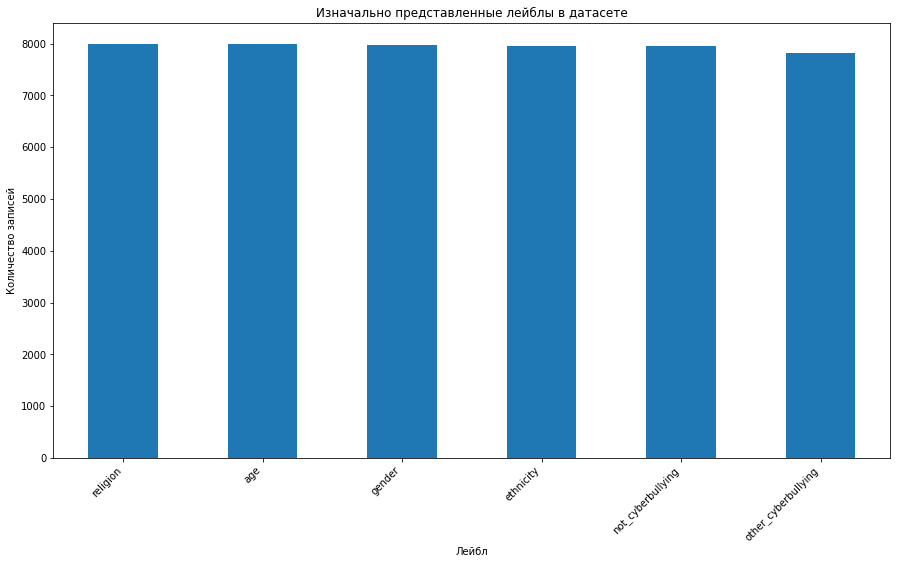

In [5]:
plt.figure(figsize=(15,8)) # задание размера фигуры
dataset[TARGET_COL].value_counts().plot.bar() # построение столбчатой диаграммы по данным
plt.xticks(rotation=45, ha='right') # поворот на 45 градусов подписей под осью OX (ha='right' ~ правый конец соответствует колонке)
plt.title("Изначально представленные лейблы в датасете") # название фигуры
plt.xlabel("Лейбл") # подпись по оси x
plt.ylabel("Количество записей") # подпись по оси y
plt.show() # показ фигуры

**В датасете имеется 6 уникальных классов, при этом он сразу сбалансирован, так как в каждом классе примерно 8000 записей.**

In [6]:
dataset.isnull().sum() # проверка наличия пропущенных значений

tweet_text            0
cyberbullying_type    0
dtype: int64

**Пропущенных значений в датасете не оказалось.**

## Отображение самых частых слов в датасете

Данный шаг помогает определить дополнительные, неявные стоп-слова.

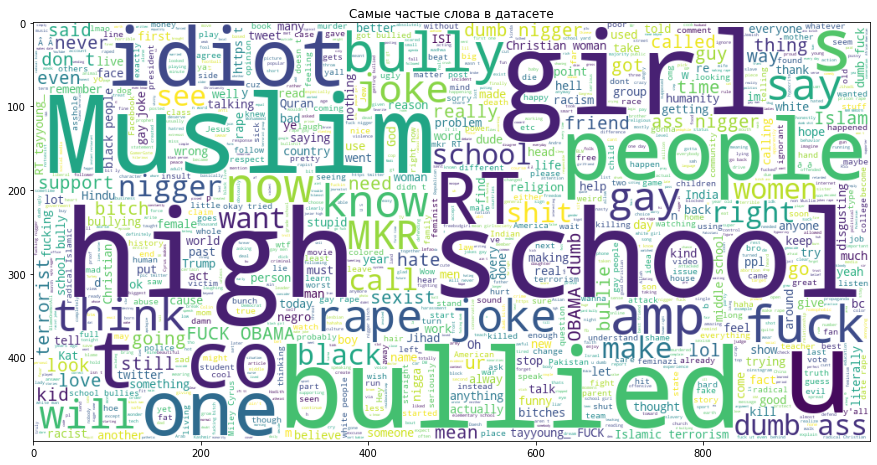

In [7]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', width=1000, height=500, random_state=RANDOM_STATE) # создание WordCloud объекта
wordcloud.generate(" ".join(dataset[DATA_COL])) # отправляем в WordCloud весь текст из датасета

plt.figure(figsize=(15,10)) # задание размера фигуры
plt.imshow(wordcloud) # отображение картинки
plt.title("Самые частые слова в датасете") # название фигуры
plt.show() # показ фигуры

## Определение важных слов для каждого класса

**Производится на дубликате датасета, чтобы посмотреть распределение токенов по классам и их важность, при этом не затронув изначальные данные.**

Считаем распределение токенов по датасету.

In [8]:
tokens_distribution = {} # словарь под распределение токенов по классам

dataset_ = dataset.copy() # делаем копию данных, чтобы не испортить оригинальные
dataset_[DATA_COL] = dataset_[DATA_COL].apply(lambda text: word_tokenize(text, language=LANGUAGE)) # разбиваем текст на слова (токены)
for target_value in dataset_[TARGET_COL].unique(): # идём по значениям таргетов
    tokens_distribution[target_value] = {} # словарь под слова с рассматриваемым таргетом
    for sequence in dataset_[dataset_[TARGET_COL] == target_value][DATA_COL]: # идём по записям (строкам в DataFrame, последовательностям токенов) с рассматриваемым таргетом
        for token in sequence: # идём по токенам в последовательности
            if token in tokens_distribution[target_value].keys(): # если токен уже был встречен в классе
                tokens_distribution[target_value][token] += 1
            else: # если токен встречается впервые
                tokens_distribution[target_value][token] = 1
tokens_distribution = pd.DataFrame(tokens_distribution) # собираем DataFrame на основе словаря
tokens_distribution.fillna(0, inplace=True) # пропущенные значения заполняем нулями - токен ни разу не встретился в таких записях

tokens_distribution # количество встреченных токенов по классам

,not_cyberbullying,gender,religion,other_cyberbullying,age,ethnicity
In,50.0,75.0,148.0,37.0,172.0,54.0
other,90.0,209.0,437.0,82.0,364.0,183.0
words,21.0,64.0,77.0,32.0,38.0,48.0
#,3285.0,2722.0,1805.0,1648.0,743.0,1118.0
katandandre,18.0,8.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...
abominable,0.0,0.0,0.0,0.0,0.0,1.0
conclave,0.0,0.0,0.0,0.0,0.0,1.0
decree,0.0,0.0,0.0,0.0,0.0,1.0
reeeeeal,0.0,0.0,0.0,0.0,0.0,1.0


Оставляем только те токены, что встречаются не слишком редко.

In [9]:
MIN_TOKEN_COUNT = 20 # минимальное число раз, сколько токен должен быть встречен
tokens_distribution = tokens_distribution[tokens_distribution.sum(axis=1) > MIN_TOKEN_COUNT] # оставляем только те токены, что встречались не менее MIN_TOKEN_COUNT раз
tokens_distribution # количество встреченных токенов по классам выше определённого минимального количества

,not_cyberbullying,gender,religion,other_cyberbullying,age,ethnicity
In,50.0,75.0,148.0,37.0,172.0,54.0
other,90.0,209.0,437.0,82.0,364.0,183.0
words,21.0,64.0,77.0,32.0,38.0,48.0
#,3285.0,2722.0,1805.0,1648.0,743.0,1118.0
katandandre,18.0,8.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...
niger,0.0,0.0,0.0,0.0,0.0,22.0
negros,0.0,0.0,0.0,0.0,0.0,53.0
MikeSimsWalker,0.0,0.0,0.0,0.0,0.0,22.0
Colton_Zappe,0.0,0.0,0.0,0.0,0.0,33.0


Переходим к распределению токенов по классам.

In [10]:
target_count = dataset_[TARGET_COL].value_counts() # число записей с определённым таргетом
for target_value in tokens_distribution.columns: # идём по значениям таргетов
    tokens_distribution[target_value] = tokens_distribution[target_value] / target_count[target_value] # считаем, насколько часто встречается токен среди записей по таргету

tokens_distribution # частота встречи токенов в записях соответствующего класса

C:\Users\User\Documents\TEMP\ipykernel_15272\4052339972.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tokens_distribution[target_value] = tokens_distribution[target_value] / target_count[target_value] # считаем, насколько часто встречается токен среди записей по таргету


,not_cyberbullying,gender,religion,other_cyberbullying,age,ethnicity
In,0.006293,0.009407,0.018505,0.004730,0.021522,0.006783
other,0.011328,0.026213,0.054639,0.010482,0.045546,0.022987
words,0.002643,0.008027,0.009627,0.004091,0.004755,0.006029
#,0.413468,0.341402,0.225681,0.210661,0.092968,0.140435
katandandre,0.002266,0.001003,0.000000,0.000128,0.000000,0.000000
...,...,...,...,...,...,...
niger,0.000000,0.000000,0.000000,0.000000,0.000000,0.002763
negros,0.000000,0.000000,0.000000,0.000000,0.000000,0.006657
MikeSimsWalker,0.000000,0.000000,0.000000,0.000000,0.000000,0.002763
Colton_Zappe,0.000000,0.000000,0.000000,0.000000,0.000000,0.004145


Уберём ещё и стоп-слова.

In [11]:
stop_words = stopwords.words(LANGUAGE) # список стоп-слов для языка
for add_stop in ADD_STOP_WORDS: # идём по дополнительным стоп-словам
    stop_words.append(add_stop) # добавляем стоп-слово

tokens_distribution.loc[[token for token in stop_words if token in tokens_distribution.index]] # частота встречи стоп-слов в датасете

,not_cyberbullying,gender,religion,other_cyberbullying,age,ethnicity
i,0.058905,0.060329,0.034634,0.160424,0.215340,0.110790
me,0.059534,0.109871,0.067517,0.098811,0.475851,0.112800
my,0.073254,0.073623,0.058640,0.099067,0.320195,0.121090
myself,0.002643,0.003888,0.002626,0.003324,0.017017,0.002763
we,0.029327,0.052427,0.089647,0.035281,0.063063,0.059540
...,...,...,...,...,...,...
shouldn,0.000000,0.001380,0.001375,0.000000,0.001627,0.001759
wasn,0.000000,0.002885,0.001375,0.000000,0.011011,0.002261
weren,0.000000,0.000878,0.000625,0.000000,0.003003,0.001005
won,0.000881,0.002258,0.004126,0.000767,0.005005,0.007788


In [12]:
tokens_distribution = tokens_distribution.loc[[token for token in tokens_distribution.index if token not in stop_words]] # удаляем стоп-слова
tokens_distribution # частота встречи токенов (без стоп-слов) в записях соответствующего класса

,not_cyberbullying,gender,religion,other_cyberbullying,age,ethnicity
In,0.006293,0.009407,0.018505,0.004730,0.021522,0.006783
words,0.002643,0.008027,0.009627,0.004091,0.004755,0.006029
#,0.413468,0.341402,0.225681,0.210661,0.092968,0.140435
katandandre,0.002266,0.001003,0.000000,0.000128,0.000000,0.000000
",",0.338704,0.828797,1.028757,0.373131,0.703954,0.632333
...,...,...,...,...,...,...
niger,0.000000,0.000000,0.000000,0.000000,0.000000,0.002763
negros,0.000000,0.000000,0.000000,0.000000,0.000000,0.006657
MikeSimsWalker,0.000000,0.000000,0.000000,0.000000,0.000000,0.002763
Colton_Zappe,0.000000,0.000000,0.000000,0.000000,0.000000,0.004145


Удаляем слова, что даже в классах встречаются слишком редко.

In [13]:
MIN_TOKEN_DISTRIBUTION = 0.0025 # минимальное частота использования токена
tokens_distribution = tokens_distribution[tokens_distribution.max(axis=1) > MIN_TOKEN_DISTRIBUTION] # оставляем только те строки, у которых частота использования слова по классу не менее MIN_TOKEN_DISTRIBUTION
tokens_distribution # частота встречи токенов в записях соответствующего класса не ниже определённого порога

,not_cyberbullying,gender,religion,other_cyberbullying,age,ethnicity
In,0.006293,0.009407,0.018505,0.004730,0.021522,0.006783
words,0.002643,0.008027,0.009627,0.004091,0.004755,0.006029
#,0.413468,0.341402,0.225681,0.210661,0.092968,0.140435
",",0.338704,0.828797,1.028757,0.373131,0.703954,0.632333
food,0.006923,0.001003,0.002626,0.002173,0.003504,0.001759
...,...,...,...,...,...,...
niger,0.000000,0.000000,0.000000,0.000000,0.000000,0.002763
negros,0.000000,0.000000,0.000000,0.000000,0.000000,0.006657
MikeSimsWalker,0.000000,0.000000,0.000000,0.000000,0.000000,0.002763
Colton_Zappe,0.000000,0.000000,0.000000,0.000000,0.000000,0.004145


Считаем важные слова для всех классов.

In [14]:
important_tokens = [] # список токенов, что вносят вклад в определение классов

# important_tokens = list(tokens_distribution.index)
for index, row in tokens_distribution.iterrows():
    if row.max() - row.mean() > 0.02: # если токен несёт разницу для классов
        important_tokens.append(index) # запоминаем его как важное слово

print(f"Число значимых токенов: {len(important_tokens)}.")

Число значимых токенов: 171.


In [15]:
print(f"Количество важных токенов для классов:")
tokens_distribution.loc[important_tokens].idxmax(axis=1).value_counts()

Количество важных токенов для классов:


religion               58
ethnicity              44
age                    32
gender                 28
not_cyberbullying       6
other_cyberbullying     3
Name: count, dtype: int64

**Можно заметить, что для классов 'not_cyberbullying' и 'other_cyberbullying' довольно мало специфичных слов. Это может вызвать затруднения в их дальнейшей класификации, потому что они могут "слиться" с другими лейблами.**

Считаем важные слова для каждого класса в частности. Для этого переводим частоту встречи слова в классе во вклад слова в класс с помощью Softmax.

In [16]:
for index, row in tokens_distribution.iterrows(): # идём по токенам
    new_row = np.exp(row)/np.sum(np.exp(row)) # считаем новое значение в строке с помощью softmax (вклад слова в таргет)
    tokens_distribution.loc[index] = np.exp(row)/np.sum(np.exp(row)) # обновляем значение
tokens_distribution

,not_cyberbullying,gender,religion,other_cyberbullying,age,ethnicity
In,0.165846,0.166364,0.167884,0.165587,0.168391,0.165928
words,0.166131,0.167027,0.167295,0.166371,0.166482,0.166694
#,0.197529,0.183795,0.163710,0.161270,0.143364,0.150333
",",0.118435,0.193341,0.236138,0.122583,0.170649,0.158855
food,0.167322,0.166334,0.166604,0.166529,0.166751,0.166460
...,...,...,...,...,...,...
niger,0.166590,0.166590,0.166590,0.166590,0.166590,0.167051
negros,0.166481,0.166481,0.166481,0.166481,0.166481,0.167593
MikeSimsWalker,0.166590,0.166590,0.166590,0.166590,0.166590,0.167051
Colton_Zappe,0.166551,0.166551,0.166551,0.166551,0.166551,0.167243


In [17]:
class_tokens = {} # словарь с важными для классов токенами
for label in tokens_distribution.columns: # идём по классам
    class_tokens[label] = list(tokens_distribution.loc[important_tokens][label].nlargest(15).index) # берём топ-10 слов, вносящих вклад в класс label среди всех важных слов important_tokens
    print(f"Для класса {label} важными токенами являются {class_tokens[label]}.")

Для класса not_cyberbullying важными токенами являются ['@', '#', 'MKR', 'mkr', ':', 'http', 'bullying', 'Kat', 'RT', 'ISIS', 'lt', 'School', 'Jews', 'elementary', 'killed'].
Для класса gender важными токенами являются ['rape', 'jokes', 'gay', 'joke', ',', '#', 'sexist', 'female', 'call', 'women', 'RT', 'funny', 'bitch', "''", '``'].
Для класса religion важными токенами являются ['.', ',', 'Muslims', 'Muslim', 'idiot', '?', 'Christian', 'idiots', 'Islam', 'You', 'support', 'terrorism', 'Islamic', 'radical', 'right'].
Для класса other_cyberbullying важными токенами являются ['@', ':', 'https', 'http', "'m", 'RT', "'s", 'fucking', 'lt', 'bullying', 'fucks', 'Idiot', 'Miley', 'elementary', "n't"].
Для класса age важными токенами являются ['school', 'high', 'bullied', 'I', 'bully', '’', 'girl', 'girls', 'bullies', 'like', '.', 'middle', 'got', 'kids', 'would'].
Для класса ethnicity важными токенами являются ['dumb', 'nigger', 'fuck', 'ass', '!', 'black', 'FUCK', 'u', 'white', 'niggers', ':

**Среди важных слов для классов, помимо очевидных, затесался и всякий мусор (как для стороннего наблюдателя). Тем не менее, мусорные значения, на примере '@', '#', ':', '!', 'https' вносят некий вклад в определение лейблов. Как их удаление скажется на качестве модели — узнаем после обучения.**

Можно отметить, что важные токены между классами тоже пересекаются, особенно это заметно у "not_cyberbullying" и "other_cyberbullying".

## Очистка датасета

Стоп-слова для удаления.

In [21]:
stop_words = stopwords.words(LANGUAGE) # список стоп-слов для английского языка
for add_stop in ADD_STOP_WORDS: # идём по дополнительным стоп-словам
    stop_words.append(add_stop) # добавляем стоп-слово
stop_words[:10] # первые 10 стоп-слов для английского языка

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

Очищаем датасет.

In [25]:
pandarallel.initialize(progress_bar=True) # запуск в параллельном режиме (с отображением прогресса выполнения)

def clear_data(df: pd.DataFrame, var, columns=["text"], stop_words=[], language=LANGUAGE) -> pd.DataFrame:
    """
    Универсальная параллельная функция для очистки датасета (лишние пробелы можно не удалять, так как word_tokenize их сам уберёт).\n
    Parameters:
        * df: рассматриваемый датасет
        * var: тип очистки
        * columns: столбцы в датасете, что будут очищаться
        * stop_words: какие стоп-слова использовать
        * language: язык датасета\n
    Returns:
        * pd.DataFrame: датасет с очищенными столбцами columns
    """
    # импортируем, так как потоки их перестанут видеть
    import re # для регулярных выражений
    # import pymorphy3 # для работы с текстом (токенами)
    from nltk.tokenize import word_tokenize # для токенизации строки


    # morph = pymorphy3.MorphAnalyzer() # объект для лемматизации слов
    lemmatizer = WordNetLemmatizer() # объект для лемматизации слов


    for column in columns: # идём по переданным столбцам для обработки
        df[column] = df[column].parallel_apply(lambda text: text.lower()) # приводим к нижнему регистру

        if var in ["trash", "all"]:
            df[column] = df[column].parallel_apply(lambda text: re.sub('@\S*', '', text)) # убираем тегирование (например @Soloviev)
            df[column] = df[column].parallel_apply(lambda text: re.sub('<.*?>', '', text)) # убираем html элементы
            df[column] = df[column].parallel_apply(lambda text: re.sub("http\S*", ' ', text)) # убираем ссылки (например https://t.co/KN1g4AWFIb)


        if var in ["punctuation", "all"]:
            df[column] = df[column].parallel_apply(lambda text: re.sub(r"[,.…?:;¦/\\!@#$#—–+=ツ►๑۞۩•«»“”˜°*`\"'’™)(<>\[\]%$&]", ' ', text)) # удаляем различную пунктуацию
            df[column] = df[column].parallel_apply(lambda text: re.sub("-", ' ', text)) # заменяем тире на пробел


        if var in ["digits", "all"]:
            df[column] = df[column].parallel_apply(lambda text: re.sub('\d', ' ', text)) # удаляем цифры


        df[column] = df[column].parallel_apply(lambda text: word_tokenize(text, language=language)) # разбиваем текст на токены
        # df[column] = df[column].parallel_apply(lambda text: [morph.parse(word)[0].normal_form for word in text]) # приводим слова к нормальной форме (если она у них есть, иначе они остаются без изменения)
        df[column] = df[column].parallel_apply(lambda text: [lemmatizer.lemmatize(word) for word in text]) # лемматизируем слова

        if var in ["stop_words", "all"]:
            df[column] = df[column].parallel_apply(lambda text: [word for word in text if word not in stop_words]) # удаляем стоп-слова

        df[column] = df[column].parallel_apply(lambda text: ' '.join(text)) # собираем токены обратно в строку
        df[column] = df[column].astype('string') # приводим колонку к типу строки (чтобы у записей не было начальных и конечных кавычек)

        # df = df[df[column].notnull()] # оставляем те строки, у которых рассматриваемый столбец имеет значение
        df = df[df[column] != ""] # оставляем те строки, данные в которых не занулились

    df.reset_index(drop=True, inplace=True) # обновляем индексы, так как они остались от предыдущего варианта датасета (inplace=True - перезаписываем существующий датасет)
    return df # возвращаем обработанный датасет

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [ ]:
for var in tqdm(CLEANING_VARS): # идём по вариантам обработки
    dataset_cleared = clear_data(dataset.copy(), var, [DATA_COL], stop_words) # проводим очистку датасета
    dataset_cleared.to_csv(f"{DATA_DIR}2_cleared/{var}.csv", sep=",", index=False) # сохраняем полученный датасет (index=False — без сохранения индексов)

## Векторизация & Train-test split

**В данном варианте рассматривается конвертация данных в TF-IDF матрицу.**

Все лейблы будут переведены в соответствующие вероятности, то есть 1 ставится на позиции правильного таргета, а на всех остальных местах — 0.

In [27]:
for var in tqdm(CLEANING_VARS): # идём по вариантам обработки
    dataset = pd.read_csv(f"{DATA_DIR}2_cleared/{var}.csv", sep=',', encoding='utf8', index_col=False) # считывание данных

    vectorizer = TfidfVectorizer(ngram_range=(1,1), lowercase=True, min_df=MIN_DF, max_df=MAX_DF, max_features=MAX_WORDS_TOKENIZER, stop_words=stop_words, dtype=DTYPE) # векторизатор (с ограничениями max_features на построение vocabulary, чтобы вектора были не слишком большие)
    encoded_data = vectorizer.fit_transform(dataset[DATA_COL]).toarray() # конвертируем документы (текста) в вектора

    data_X = pd.DataFrame(encoded_data, columns=vectorizer.get_feature_names_out()) # конвертируем вектора в DataFrame
    data_y = pd.get_dummies(dataset[TARGET_COL], dtype=DTYPE) # делаем One-hot encoding для таргетов
    labels = data_y.columns # уникальные значения таргетов (колонки One-hot encodding таргетов)
    print(f"При очистке '{var}' размерность данных: сэмплов — {data_X.shape[0]}, фич — {data_X.shape[1]}, таргетов — {data_y.shape[1]}.")

    X_train, X_test, y_train, y_test = train_test_split(data_X, data_y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=data_y, shuffle=True)
    # разбиваем датасет (data_X — данные, data_y — One-hot encoded таргеты) на обучающую и тестовую выборки в соотношении TEST_SIZE, при этом пропорция таргетов должна быть одинаковой (stratify=data_y) в обоих выборках и данные должны быть перемешаны (shuffle=True)

    X_train.to_csv(f"{DATA_DIR}3_splited/X_train/{var}_tfidf.csv", sep=",", index=False) # сохраняем X_train (index=False — без сохранения индексов)
    X_test.to_csv(f"{DATA_DIR}3_splited/X_test/{var}_tfidf.csv", sep=",", index=False) # сохраняем X_test (index=False — без сохранения индексов)
    y_train.to_csv(f"{DATA_DIR}3_splited/y_train/{var}_tfidf.csv", sep=",", index=False) # сохраняем y_train (index=False — без сохранения индексов)
    y_test.to_csv(f"{DATA_DIR}3_splited/y_test/{var}_tfidf.csv", sep=",", index=False) # сохраняем y_test (index=False — без сохранения индексов)

  0%|          | 0/5 [00:00<?, ?it/s]

При очистке 'none' размерность данных: сэмплов — 47692, фич — 3453, таргетов — 6.
При очистке 'trash' размерность данных: сэмплов — 47469, фич — 3312, таргетов — 6.
При очистке 'stop_words' размерность данных: сэмплов — 47691, фич — 3453, таргетов — 6.
При очистке 'punctuation' размерность данных: сэмплов — 47689, фич — 3449, таргетов — 6.
При очистке 'all' размерность данных: сэмплов — 47360, фич — 3262, таргетов — 6.


In [28]:
data_X # пример получившихся векторизованных данных

,ab,ability,able,abortion,absolute,absolutely,abt,abuse,abused,abuser,...,younger,youre,youth,youtube,ypg,yr,yu,yup,zero,zionist
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47355,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47357,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.426872,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
data_y # пример получившихся таргетов

,age,ethnicity,gender,not_cyberbullying,other_cyberbullying,religion
0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...
47355,0.0,1.0,0.0,0.0,0.0,0.0
47356,0.0,1.0,0.0,0.0,0.0,0.0
47357,0.0,1.0,0.0,0.0,0.0,0.0
47358,0.0,1.0,0.0,0.0,0.0,0.0


# Обучение моделей

In [16]:
metrics = {} # словарь под метрику

## Classical ML

In [17]:
models_classic = {} # словарь под полученные классификаторы вида
# {"classifier 1":
#   {
#     "var 1": классификатор,
#     "var 2": классификатор,
#     ...
#   }, ...
# }

In [18]:
custom_cv = ShuffleSplit(n_splits=CV_SPLITS, test_size=TEST_SIZE, random_state=RANDOM_STATE) # кастомный кросс-валидатор
# n_splits — число разбиений для кросс-валидации
# test_size — размер тестовой выборки

### Вспомогательные функции

In [19]:
def model_train(model, params, X_train, y_train, cv, n_jobs=N_JOBS, verbose=VERBOSE, scoring="f1_macro") -> GridSearchCV:
    """
    Универсальная функция для обучения классификаторов.\n
    Parameters:
        * model: классификатор
        * params: параметры для перебора в GreedSearch
        * X_train: данные для обучения
        * y_train: таргеты для обучения
        * cv: метод для кросс-валидации
        * n_jobs: количество потоков для распараллеливания
        * verbose: на сколько подробным должен быть вывод при обучении
        * scoring: метрика для выбора лучшей модели\n
    Returns:
        * GridSearchCV: объект, содержащий
    """
    greed_search = GridSearchCV(model, params, cv=cv , scoring=scoring, n_jobs=n_jobs, verbose=verbose) # передаём параметры в GridSearchCV
    greed_search.fit(X_train, y_train) # обучаем модель    
    return greed_search # возвращаем обученный классификатор

In [20]:
def models_best(models_gs):
    best_classifier = None # лучший классификатор
    best_score = 0 # лучший score
    best_var = None # лучший вариант предобработки

    for var in CLEANING_VARS: # идём по вариантам обработки
        if models_gs[var].best_score_ > best_score:
            best_score = models_gs[var].best_score_
            best_classifier = models_gs[var].best_estimator_
            best_var = var
    print(f"Лучший score={best_score:.4f} при обработке '{best_var}'.")
    return best_classifier, best_var

In [21]:
def get_metrics(models_gs, metrics: dict):
    for var in CLEANING_VARS: # идём по вариантам обработки
        metrics[var] = models_gs[var].best_score_

In [115]:
def model_evaluate(model, X_test, y_test, labels_names=None):
    preds = model.predict(X_test) # делаем предсказание

    if labels_names is None:
        labels_names = y_test.columns # названия таргетов
    if preds.ndim > 1: # если размерность предсказаний больше 1, то есть вектора (размерность 2 — вероятности лейблов) — приводим их к вектору
        preds = np.argmax(preds, axis=1)  # приводим One-hot encoded предсказания в id ожидаемого таргета
    if y_test.ndim > 1: # если размерность лейблов больше 1, то есть вектора (размерность 2 — вероятности лейблов) — приводим их к вектору
        y_test = np.argmax(y_test, axis=1) # приводим One-hot encoded лейблы в id ожидаемого таргета

    print(classification_report(y_test, preds, target_names=labels_names, zero_division=0)) # выводим основные метрики, такие как precision, recall, f1-score, accuracy (zero_division=0 — деление на ноль заменять нулём)

    fig, ax = plt.subplots(figsize=(10,10)) # создание "фигуры"
    ConfusionMatrixDisplay(confusion_matrix(y_test, preds), display_labels=labels_names).plot(ax=ax) # строим confusion matrix
    fig.autofmt_xdate(rotation=45, ha='right') # поворот подписей на оси OX

In [23]:
def model_save(model, file_name):
    with open(f"{MODELS_DIR}{file_name}.pkl", 'wb') as f: # открытие файла для бинарной ('b') записи ('w')
        pickle.dump(model, f) # сохраняем модель

In [24]:
def model_load(file_name):
    with open(f"{MODELS_DIR}{file_name}.pkl", 'rb') as f: # открытие бинарного ('b') файла для чтения ('r')
        return pickle.load(f) # загружаем модель

### 1) K-Nearest Neighbors (KNN)

В качестве первой простой модели рассмотрим ***KNN***, что предсказывает класс по известным K ближайшим соседям.

In [25]:
params_KNN = [{
    'n_neighbors': list(range(1, 10, 2)), # кол-во соседей
    'weights': ['uniform', 'distance'], # вдияние расстояния до соседа на его вклад ("uniform" — нет влияния, "distance" — чем ближе, тем больше вклад)
    'metric': ["minkowski"], # метрика для подсчёта расстояния между объектами
    'p': [2], # степень в метрике Минковского расстояния (2 ~ расстояние евклидово)
    'algorithm': ['auto'], # алгоритм для подсчёта ближайших соседей
    }]

model_name = "KNN" # название модели

In [26]:
models_classic[model_name] = {} # создаём заготовку под классификатор

for var in tqdm(CLEANING_VARS): # идём по вариантам обработки
    X_train = pd.read_csv(f"{DATA_DIR}3_splited/X_train/{var}_tfidf.csv", sep=',', encoding='utf8', index_col=False) # считывание данных
    y_train = pd.read_csv(f"{DATA_DIR}3_splited/y_train/{var}_tfidf.csv", sep=',', encoding='utf8', index_col=False) # считывание данных
    # y_train = y_train.idxmax(axis=1).factorize(sort=True)[0] # использование id классов вместо вероятностей

    time_start = time.time() # замеряем время начала обучения
    gs_model = model_train(KNeighborsClassifier(), params_KNN, X_train, y_train, custom_cv) # вызываем функцию обучения
    print(f"Время, затраченное на обучение: {time.time()  - time_start} секунд, при обработке {var}.")
    models_classic[model_name][var] = gs_model # сохраняем то, что вернул GreedSearch

  0%|          | 0/5 [00:00<?, ?it/s]

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Время, затраченное на обучение: 566.9557158946991 секунд, при обработке none.
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Время, затраченное на обучение: 559.6707317829132 секунд, при обработке trash.
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Время, затраченное на обучение: 572.9282183647156 секунд, при обработке stop_words.
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Время, затраченное на обучение: 616.9440362453461 секунд, при обработке punctuation.
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Время, затраченное на обучение: 580.5141079425812 секунд, при обработке all.


Находим лучшую комбинацию параметров модели и обработки датасета.

In [27]:
best_model, best_var = models_best(models_classic[model_name]) # находим лучшую комбинацию параметров модели и обработки датасета

Лучший score=0.4077 при обработке 'punctuation'.


In [28]:
print(f"Лучший вариант обработки для {model_name} — {best_var}. Параметры модели:")
best_model.get_params() # лучшие параметры

Лучший вариант обработки для KNN — punctuation. Параметры модели:


{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 1,
 'p': 2,
 'weights': 'uniform'}

In [29]:
model_save(best_model, f"{model_name}_tfidf_{best_var}") # сохраняем лучшую модель (с указанием варианта очистки текста)

Оцениваем качество предсказаний.

In [30]:
metrics[model_name] = {}
get_metrics(models_gs=models_classic[model_name], metrics=metrics[model_name]) # запоминаем лучшие метрики

In [225]:
# best_var = "punctuation" # название лучшей обработки данных
best_model = model_load(f"{model_name}_tfidf_{best_var}") # загружаем сохранённую модель

                     precision    recall  f1-score   support

                age       0.89      0.26      0.41      1598
          ethnicity       0.92      0.54      0.68      1592
             gender       0.79      0.39      0.52      1595
  not_cyberbullying       0.45      0.35      0.39      1589
other_cyberbullying       0.17      0.64      0.27      1564
           religion       0.85      0.17      0.28      1600

           accuracy                           0.39      9538
          macro avg       0.68      0.39      0.43      9538
       weighted avg       0.68      0.39      0.43      9538



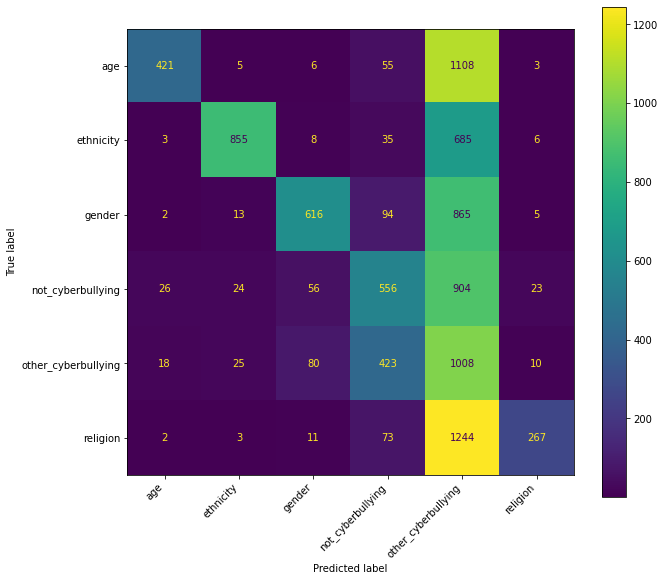

In [226]:
X_test = pd.read_csv(f"{DATA_DIR}3_splited/X_test/{best_var}_tfidf.csv", sep=',', encoding='utf8', index_col=False) # считывание данных
y_test = pd.read_csv(f"{DATA_DIR}3_splited/y_test/{best_var}_tfidf.csv", sep=',', encoding='utf8', index_col=False) # считывание данных

model_evaluate(best_model, X_test, y_test) # оцениваем предсказание лучшей модели на соответствующем типе обработки

KNN с задачей классификации справился **не удовлетворительно**. Модель старалась отнести все записи к классу "other_cyberbulling", что может быть связано с его плохой векторной репрезентацией (из-за остуствия каких-либо специфических для лейбла слов — вектора соответствующих текстов могли быть разбросаны повсеместно, рядом с записями о других классах).

Тем не менее, для части записей KNN всё же правильно предсказывала классы, почему и смогла достичь ***accuracy в 0.39 и F-score 0.43*** при обработке '***punctuation***'.

### 2) Random Forest

В качестве второй модели попробуем использовать **Random Forest**, что является группой Decision Tree, которым на вход подаются разные части входных данных (но с указанием классов). Деревья в Random Forest разделяют входные данные таким образом, чтобы минимизировать энтропию лейблов на каждом уровне.

In [33]:
params_RF = [{
    "n_estimators": [20, 50], # число деревьев в ансамбле
    "criterion": ["gini", "entropy"], # критерий для оценивания качества разбиения
    "max_depth": [5, 10], # лимит на максимальную глубину деревьев в ансамбле
    "min_samples_split": [10, 50, 100],# минимальное число сэмплов в узле для разбиения
    "max_features": ["sqrt", "log2"], # число рассматриваемых фич ('столбцов' в датасете) при делении в узле (для best split)
    "class_weight": [None, "balanced"], # балансировка весов для классов
    "random_state": [RANDOM_STATE], # число для задания случайности
    }]

model_name = "RF" # название модели

In [34]:
models_classic[model_name] = {} # создаём заготовку под классификатор

for var in tqdm(CLEANING_VARS): # идём по вариантам обработки
    X_train = pd.read_csv(f"{DATA_DIR}3_splited/X_train/{var}_tfidf.csv", sep=',', encoding='utf8', index_col=False) # считывание данных
    y_train = pd.read_csv(f"{DATA_DIR}3_splited/y_train/{var}_tfidf.csv", sep=',', encoding='utf8', index_col=False) # считывание данных
    # y_train = y_train.idxmax(axis=1).factorize(sort=True)[0] # использование id классов вместо вероятностей

    time_start = time.time() # замеряем время начала обучения
    gs_model = model_train(RandomForestClassifier(), params_RF, X_train, y_train, custom_cv) # вызываем функцию обучения
    print(f"Время, затраченное на обучение: {time.time()  - time_start} секунд, при обработке {var}.")
    models_classic[model_name][var] = gs_model # сохраняем то, что вернул GreedSearch

  0%|          | 0/5 [00:00<?, ?it/s]

Fitting 2 folds for each of 96 candidates, totalling 192 fits
Время, затраченное на обучение: 366.4860587120056 секунд, при обработке none.
Fitting 2 folds for each of 96 candidates, totalling 192 fits
Время, затраченное на обучение: 343.94261479377747 секунд, при обработке trash.
Fitting 2 folds for each of 96 candidates, totalling 192 fits
Время, затраченное на обучение: 348.80909156799316 секунд, при обработке stop_words.
Fitting 2 folds for each of 96 candidates, totalling 192 fits
Время, затраченное на обучение: 344.58736658096313 секунд, при обработке punctuation.
Fitting 2 folds for each of 96 candidates, totalling 192 fits
Время, затраченное на обучение: 331.1522877216339 секунд, при обработке all.


Находим лучшую комбинацию параметров модели и обработки датасета.

In [35]:
best_model, best_var = models_best(models_classic[model_name]) # находим лучшую комбинацию параметров модели и обработки датасета

Лучший score=0.3973 при обработке 'punctuation'.


In [36]:
print(f"Лучший вариант обработки для {model_name} — {best_var}. Параметры модели:")
best_model.get_params() # лучшие параметры

Лучший вариант обработки для RF — punctuation. Параметры модели:


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 50,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 20,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [37]:
model_save(best_model, f"{model_name}_tfidf_{best_var}") # сохраняем лучшую модель (с указанием варианта очистки текста)

Оцениваем качество предсказаний.

In [38]:
metrics[model_name] = {}
get_metrics(models_gs=models_classic[model_name], metrics=metrics[model_name]) # запоминаем лучшие метрики

In [223]:
# best_var = "punctuation" # название лучшей обработки данных
best_model = model_load(f"{model_name}_tfidf_{best_var}") # загружаем сохранённую модель

                     precision    recall  f1-score   support

                age       0.21      1.00      0.35      1598
          ethnicity       1.00      0.60      0.75      1592
             gender       1.00      0.47      0.64      1595
  not_cyberbullying       0.00      0.00      0.00      1589
other_cyberbullying       0.00      0.00      0.00      1564
           religion       0.99      0.14      0.24      1600

           accuracy                           0.37      9538
          macro avg       0.53      0.37      0.33      9538
       weighted avg       0.53      0.37      0.33      9538



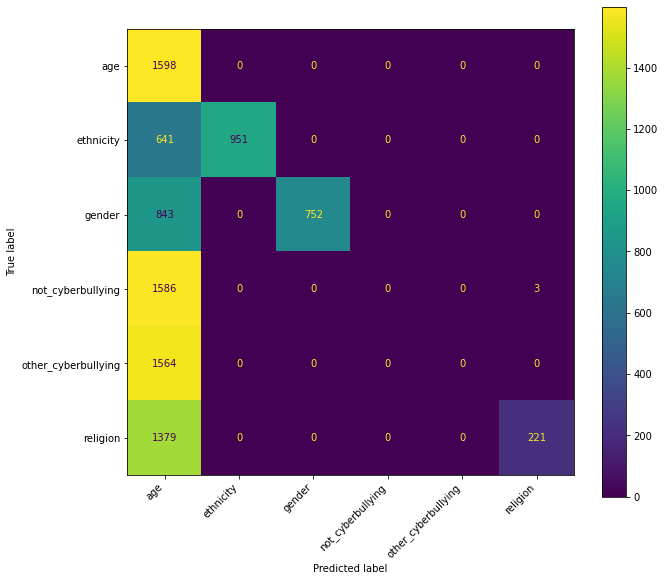

In [224]:
X_test = pd.read_csv(f"{DATA_DIR}3_splited/X_test/{best_var}_tfidf.csv", sep=',', encoding='utf8', index_col=False) # считывание данных
y_test = pd.read_csv(f"{DATA_DIR}3_splited/y_test/{best_var}_tfidf.csv", sep=',', encoding='utf8', index_col=False) # считывание данных

model_evaluate(best_model, X_test, y_test) # оцениваем предсказание лучшей модели на соответствующем типе обработки

Random Forest показал **результаты хуже KNN**. Некоторые лейблы, такие как "not_cyberbullying" и "other_cyberbullying" модель совсем не научилась распознавать, возможно из-за того, что их сложно отделить от текстов других классов (минимизировать энтропию). Большинство записей она уже относила к "age", а не к "other_cyberbullying". И при лучшемм варианте обработки (**punctuation**) смогла достичь лишь ***accuracy=0.37 и F-score=0.33***.

Однако занимательно, что в отличае от KNN, Random Forest не путал классы между собой, а путал их только с 'age' (нули в confusion matrix). 

### 3) Stacking ensemble, основанный на простых моделях

Так как предыдущие модели хорошо предсказывали отдельные разные классы, попробуем их объединить в ансамбль для хорошего предсказания сразу всех классов:
* В качестве простых моделей на первом слое будут использоваться сразу несколько классификаторов, а именно — **KNN**, **Random Forest**, Naive Bayes classifier for multinomial models (**MultinomialNB**).
* Результат работы первого слоя будет передаваться в логистическую регрессию (**Logistic Regression**), которая, в свою очередь, и будет давать финальное предсказание.

In [41]:
params_ensemble = [{
    # параметры KNN
    'knn_1__n_neighbors': [3], # кол-во соседей
    'knn_1__weights': ['distance'], # вдияние расстояния до соседа на его вклад ("uniform" — нет влияния, "distance" — чем ближе, тем больше вклад)
    'knn_1__metric': ['minkowski'], # метрика для подсчёта расстояния между объектами
    'knn_1__p': [2], # степень в метрике Минковского расстояния (2 ~ расстояние евклидово)
    'knn_1__algorithm': ['auto'], # алгоритм для подсчёта ближайших соседей

    # параметры Random Forest
    'rf_1__n_estimators': [20], # число деревьев в ансамбле
    'rf_1__criterion': ["entropy"], # критерий для оценивания качества разбиения
    'rf_1__max_depth': [10], # лимит на максимальную глубину деревьев в ансамбле
    'rf_1__min_samples_split': [50], # минимальное число сэмплов в узле для разбиения
    'rf_1__max_features': ['sqrt'], # число рассматриваемых фич ('столбцов' в датасете) при делении в узле (для best split)
    'rf_1__class_weight': [None], # балансировка весов для классов
    'rf_1__random_state': [RANDOM_STATE], # число для задания случайности

    # параметры Multinomial Naive Bayes
    "mnb_1__alpha": [1.0], # Additive (Laplace/Lidstone) smoothing parameter (set alpha=0 and force_alpha=True, for no smoothing).
    "mnb_1__force_alpha": [True], # If False and alpha is less than 1e-10, it will set alpha to 1e-10. If True, alpha will remain unchanged. This may cause numerical errors if alpha is too close to 0.
    "mnb_1__fit_prior": [True], # нужно ли считать априорные вероятности классов (если False — используется равномерное распрежедение)
    "mnb_1__class_prior": [None], # априорные вероятности классов (если None — назначаются по входным данным)

    # параметры Logistic Regression
    "final_estimator__penalty": ["l2"], # тип штрафа за неправильное предсказание
    "final_estimator__C": [1.0], # параметр регуляризации (чем меньше — тем сильнее регуляризация)
    "final_estimator__class_weight": ["balanced"], # балансировка весов для классов
    "final_estimator__solver": ["lbfgs"], # алгоритм, используемый для оптимизации решения
    "final_estimator__max_iter": [500], # максимальное число итерация для solver, чтобы сойтись
    "final_estimator__warm_start": [False], # использовать ли решение с предыдущего вызова fit, как начальное
    "final_estimator__random_state": [RANDOM_STATE] # число для задания случайности
    }]

layer_one_estimators = [ # первый слой Stacking ансамбля, состоящий из следующих моделей:
                        ('knn_1', KNeighborsClassifier()), # KNN
                        ('rf_1', RandomForestClassifier()), # Decision Tree
                        ('mnb_1', MultinomialNB()) # Naive Bayes classifier for multinomial models
                       ]

final_estimator = LogisticRegression() # финальное предсказание делает логистическая регрессия (в sklearn есть встроенный LabelEncoder, что строковые таргеты конвертирует в числа, поэтому регрессия может работать без ручного приведения таргетов к числовому формату)

model_name = "SE" # название модели

In [42]:
ensemble = StackingClassifier(estimators=layer_one_estimators, final_estimator=final_estimator) # создаём Stacking ансамбль, на первом уровне которого идут модели, указаные в layer_one_estimators, а на финальном — final_estimator
ensemble

StackingClassifier(estimators=[('knn_1', KNeighborsClassifier()),
                               ('rf_1', RandomForestClassifier()),
                               ('mnb_1', MultinomialNB())],
                   final_estimator=LogisticRegression())

In [50]:
models_classic[model_name] = {} # создаём заготовку под классификатор

for var in tqdm(CLEANING_VARS): # идём по вариантам обработки
    X_train = pd.read_csv(f"{DATA_DIR}3_splited/X_train/{var}_tfidf.csv", sep=',', encoding='utf8', index_col=False) # считывание данных
    y_train = pd.read_csv(f"{DATA_DIR}3_splited/y_train/{var}_tfidf.csv", sep=',', encoding='utf8', index_col=False) # считывание данных
    y_train = y_train.idxmax(axis=1).factorize(sort=True)[0] # использование id классов вместо вероятностей

    time_start = time.time() # замеряем время начала обучения
    gs_model = model_train(ensemble, params_ensemble, X_train, y_train, custom_cv) # вызываем функцию обучения
    print(f"Время, затраченное на обучение: {time.time()  - time_start} секунд, при обработке {var}.")
    models_classic[model_name][var] = gs_model # сохраняем то, что вернул GreedSearch

  0%|          | 0/5 [00:00<?, ?it/s]

Fitting 2 folds for each of 1 candidates, totalling 2 fits
Время, затраченное на обучение: 522.6073579788208 секунд, при обработке none.
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Время, затраченное на обучение: 441.6563518047333 секунд, при обработке trash.
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Время, затраченное на обучение: 476.9789791107178 секунд, при обработке stop_words.
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Время, затраченное на обучение: 481.0627484321594 секунд, при обработке punctuation.
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Время, затраченное на обучение: 457.1737365722656 секунд, при обработке all.


Находим лучшую комбинацию параметров модели и обработки датасета.

In [52]:
best_model, best_var = models_best(models_classic[model_name]) # находим лучшую комбинацию параметров модели и обработки датасета

Лучший score=0.8325 при обработке 'punctuation'.


In [53]:
print(f"Лучший вариант обработки для {model_name} — {best_var}. Параметры модели:")
best_model.get_params() # лучшие параметры

Лучший вариант обработки для Stacking_ensemble — punctuation. Параметры модели:


{'cv': None,
 'estimators': [('knn_1',
   KNeighborsClassifier(n_neighbors=3, weights='distance')),
  ('rf_1',
   RandomForestClassifier(criterion='entropy', max_depth=10, min_samples_split=50,
                          n_estimators=20, random_state=42)),
  ('mnb_1', MultinomialNB(force_alpha=True))],
 'final_estimator__C': 1.0,
 'final_estimator__class_weight': 'balanced',
 'final_estimator__dual': False,
 'final_estimator__fit_intercept': True,
 'final_estimator__intercept_scaling': 1,
 'final_estimator__l1_ratio': None,
 'final_estimator__max_iter': 500,
 'final_estimator__multi_class': 'auto',
 'final_estimator__n_jobs': None,
 'final_estimator__penalty': 'l2',
 'final_estimator__random_state': 42,
 'final_estimator__solver': 'lbfgs',
 'final_estimator__tol': 0.0001,
 'final_estimator__verbose': 0,
 'final_estimator__warm_start': False,
 'final_estimator': LogisticRegression(class_weight='balanced', max_iter=500, random_state=42),
 'n_jobs': None,
 'passthrough': False,
 'stack_met

In [54]:
model_save(best_model, f"{model_name}_tfidf_{best_var}") # сохраняем лучшую модель (с указанием варианта очистки текста)

Оцениваем качество предсказаний.

In [55]:
metrics[model_name] = {}
get_metrics(models_gs=models_classic[model_name], metrics=metrics[model_name]) # запоминаем лучшие метрики

In [220]:
# best_var = "punctuation" # название лучшей обработки данных
best_model = model_load(f"{model_name}_tfidf_{best_var}") # загружаем сохранённую модель

                     precision    recall  f1-score   support

                age       0.94      0.97      0.95      1598
          ethnicity       0.96      0.96      0.96      1592
             gender       0.89      0.82      0.86      1595
  not_cyberbullying       0.64      0.58      0.61      1589
other_cyberbullying       0.63      0.71      0.66      1564
           religion       0.94      0.95      0.95      1600

           accuracy                           0.83      9538
          macro avg       0.83      0.83      0.83      9538
       weighted avg       0.83      0.83      0.83      9538



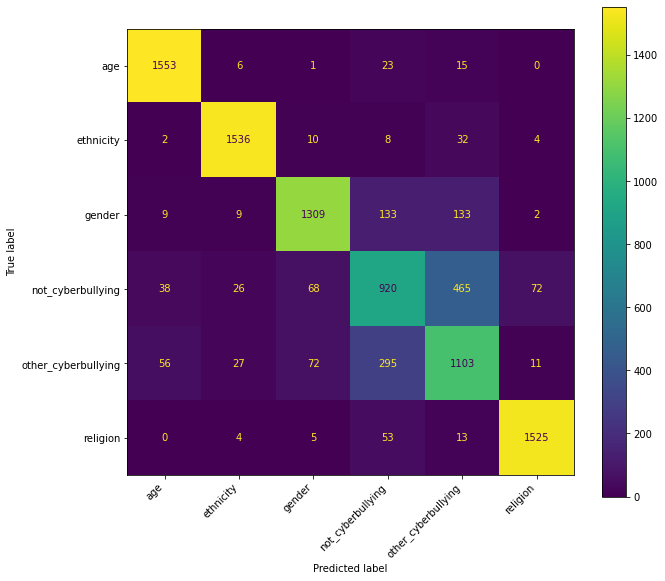

In [221]:
X_test = pd.read_csv(f"{DATA_DIR}3_splited/X_test/{best_var}_tfidf.csv", sep=',', encoding='utf8', index_col=False) # считывание данных
y_test = pd.read_csv(f"{DATA_DIR}3_splited/y_test/{best_var}_tfidf.csv", sep=',', encoding='utf8', index_col=False) # считывание данных

labels_names = y_test.columns # имена колонок
y_test = y_test.idxmax(axis=1).factorize(sort=True)[0] # использование id классов вместо вероятностей
model_evaluate(best_model, X_test, y_test, labels_names) # оцениваем предсказание лучшей модели на соответствующем типе обработки

**В итоге получился ансамбль моделей, что стал хорошо предсказывать все классы сразу!**

У ансамбля практически идеальные предсказания для всех классов кибербуллинга, кроме "not_cyberbullying" и "other_cyberbullying", что как раз были плохо различимы ещё на этапе анализа важных токенов.

Лучший вариант предобработки остался неизменным — **punctuation**, ***accuracy и F-score при нём равны 0.83***.

## Neural networks

### Вспомогательные функции

Callback функции.

In [214]:
def get_early_stopping(epochs_patience=EPOCHS_PATIENCE):
    """
    This function should return an EarlyStopping callback that stops learning when the
    validation (testing) accuracy has not improved over the last N epochs.
    """
    early_stopping = EarlyStopping(monitor="val_f1_score", mode="max", patience=epochs_patience) # callback ранней остановки обучения
    # monitor — по какой метрике судить, нужно ли прекращать обучение, например - val_loss или loss
    # mode — метрика должна увеличиваться (max) или уменьшаться (min)
    # patience — сколько должно пройти эпох без улучшения отслеживаемой метрики чтобы прекратить обучение
    return early_stopping


def get_checkpoint_best_only(file_name):
    """
    This function should return a ModelCheckpoint object that:
    - stores only those weights of the neural network that generate the highest accuracy during testing
    - saves to the 'checkpoints_best_only' directory inside the current working directory
    - generates a file named '{MODELS_DIR}{file_name}.keras'
    """
    checkpoint_best = ModelCheckpoint(filepath=f"{MODELS_DIR}{file_name}.keras", save_best_only=True, save_weights_only=False, monitor="val_f1_score", mode="max") # callback сохранения чекпоинтов модели
    # filepath — путь до файла, куда сохранять (можно с указанием эпохи...)
    # save_best_only — сохранять только если результат (отслеживаемая метрика) улучшилась
    # save_weights_only — сохранять ли только веса
    # monitor — по какой метрике судить, стала ли модель лучше/хуже
    # mode — метрика должна увеличиваться (max) или уменьшаться (min)
    return checkpoint_best

In [ ]:
def plot_history(history):
    fig = plt.figure(constrained_layout=True, figsize=(24,40)) # создаём фигуру

    subfigs = fig.subfigures(nrows=len(CLEANING_VARS), ncols=1) # добавляем подфигуры (под var обработки)
    for i, subfig in enumerate(subfigs): # идём по подфигурам (placeholder для графиков каждой обработки)
        # берём данные об обучении
        var = CLEANING_VARS[i] # рассматриваемый тип обработки
        history_ = history[var].history # словарь с историей обучения
        epochs = range(1, len(history_["loss"]) + 1) # число эпох обучения (сколько было сохранено значений loss)
        loss_train = history_["loss"] # значение loss при обучении
        loss_test = history_["val_loss"] # значение loss при валидации
        accuracy_train = history_["accuracy"] # значение accuracy при обучении
        accuracy_test = history_["val_accuracy"] # значение accuracy при валидации
        f_score_train = history_["f1_score"] # значение F-score при обучении
        f_score_test = history_["val_f1_score"] # значение F-score при обучении

        best_epoch = f_score_test.index(max(f_score_test)) + 1 # эпоха с наилучшим f-score (+1 из-за нумерации с 0)

        # строим графики
        subfig.suptitle(f"Тип обработки {var}:", fontsize=24)

        axes = subfig.subplots(nrows=1, ncols=3) # добавляем подфигуры (под метрики)
        axes[0].plot(epochs, loss_train, color="b", label="Loss при обучении") # построение графика
        axes[0].plot(epochs, loss_test, color="r", label="Loss при валидации") # построение графика
        axes[0].plot(best_epoch, loss_test[best_epoch-1], 'o', label="Loss на сохранённой модели") # выводим точку, где была найдена лучшая модель
        # axes[i][0].set_xticklabels(axes[0].get_xticklabels(), ha='right', rotation=45) # добавление rotation для существующих xticks (get_xticklabels) с выравниванием по правому концу (ha='right')
        axes[0].set_title("Изменение значения loss функции в зависимости от эпохи обучения") # название фигуры
        axes[0].set_xlabel("Эпоха") # подпись по оси OX
        axes[0].set_ylabel("Cross-entropy loss") # подпись по оси OY
        axes[0].legend() # отображение подписей графиков

        axes[1].plot(epochs, accuracy_train, color="b", label="Accuracy при обучении") # построение графика
        axes[1].plot(epochs, accuracy_test, color="r", label="Accuracy при валидации") # построение графика
        axes[1].plot(best_epoch, accuracy_test[best_epoch-1], 'o', label="Accuracy на сохранённой модели") # выводим точку, где была найдена лучшая модель
        # axes[i][1].set_xticklabels(axes[1].get_xticklabels(), ha='right', rotation=45) # добавление rotation для существующих xticks (get_xticklabels) с выравниванием по правому концу (ha='right')
        axes[1].set_title("Изменение значения accuracy в зависимости от эпохи обучения") # название фигуры
        axes[1].set_xlabel("Эпоха") # подпись по оси OX
        axes[1].set_ylabel("Accuracy") # подпись по оси OY
        axes[1].legend() # отображение подписей графиков

        axes[2].plot(epochs, f_score_train, color="b", label="F-score при обучении") # построение графика
        axes[2].plot(epochs, f_score_test, color="r", label="F-score при валидации") # построение графика
        axes[2].plot(best_epoch, f_score_test[best_epoch-1], 'o', label="F-score на сохранённой модели") # выводим точку, где была найдена лучшая модель
        # axes[i][2].set_xticklabels(axes[1].get_xticklabels(), ha='right', rotation=45) # добавление rotation для существующих xticks (get_xticklabels) с выравниванием по правому концу (ha='right')
        axes[2].set_title("Изменение значения F-score в зависимости от эпохи обучения") # название фигуры
        axes[2].set_xlabel("Эпоха") # подпись по оси OX
        axes[2].set_ylabel("F-score") # подпись по оси OY
        axes[2].legend() # отображение подписей графиков

    plt.show() # показ фигуры

### 1) Полносвязная нейронная сеть

В качестве первой рассмотренной NN будет обычная **полносвязная сеть**, состоящая из нескольких линейных слоёв с dropout между ними для предотвращения переобучения.

Функция построения модели.

In [74]:
def create_model_FC(input_size: int, target_size: int) -> Model:
    """
    Функция для создания полносвязной последовательной модели с различным shape входа.\n
    Parameters
    -------
    * input_size : ожидаемый размер входа модели (количество фич на один сэмпл данных)
    * target_size : ожидаемое число таргетов
    Returns
    -------
    * Model : созданная модель
    """
    layer_input = Input(shape=(input_size,), dtype=DTYPE, name='input_tfidf') # первый входной слой модели, получает вектор размера (BATCH_SIZE, число слов или токенов в строке матрицы TF-IDF)
    layer_linear_1 = Dense(units=512, activation="relu", name='dense_1')(layer_input) # полносвязный (линейный) слой, выход которого имеет размерность (BATCH_SIZE, units)
    layer_dropout_1 = Dropout(rate=0.1, name='dropout_1')(layer_linear_1) # слой dropout, зануляющий некоторые входы с вероятностью rate для борьбы с переобучением
    layer_linear_2 = Dense(units=256, activation="relu", name='dense_2')(layer_dropout_1) # полносвязный (линейный) слой, выход которого имеет размерность (BATCH_SIZE, units)
    layer_linear_3 = Dense(units=128, activation="relu", name='dense_3')(layer_linear_2) # полносвязный (линейный) слой, выход которого имеет размерность (BATCH_SIZE, units)
    layer_dropout_2 = Dropout(rate=0.1, name='dropout_2')(layer_linear_3) # слой dropout, зануляющий некоторые входы с вероятностью rate для борьбы с переобучением
    layer_output = Dense(units=target_size, activation="softmax", name='labels_prob')(layer_dropout_2) # полносвязный (линейный) слой, activation="softmax" — для получения вероятностей классов, выход будет иметь размерность (BATCH_SIZE, units)
    model = Model(inputs=layer_input, outputs=layer_output) # объединение слоёв в модель
    
    return model

In [75]:
model_example = create_model_FC(3000, 6) # создаём модель (для примера вывода архитектуры)
model_example.summary() # вывод данных о модели


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_tfidf (InputLayer)    [(None, 3000)]            0         
                                                                 
 dense_1 (Dense)             (None, 512)               1536512   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dense_3 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 labels_prob (Dense)         (None, 6)                 774  

Обучение модели.

In [79]:
model_name = "FC" # название модели

In [91]:
history = {} # словарь под историю обучения

for var in tqdm(CLEANING_VARS): # идём по вариантам обработки
    X_train = pd.read_csv(f"{DATA_DIR}3_splited/X_train/{var}_tfidf.csv", sep=',', encoding='utf8', index_col=False).values # считывание данных
    y_train = pd.read_csv(f"{DATA_DIR}3_splited/y_train/{var}_tfidf.csv", sep=',', encoding='utf8', index_col=False).values # считывание данных
    X_test = pd.read_csv(f"{DATA_DIR}3_splited/X_test/{var}_tfidf.csv", sep=',', encoding='utf8', index_col=False).values # считывание данных
    y_test = pd.read_csv(f"{DATA_DIR}3_splited/y_test/{var}_tfidf.csv", sep=',', encoding='utf8', index_col=False).values # считывание данных

    input_size = X_train.shape[1] # размер входного вектора (для одного сэмпла)
    target_size = y_train.shape[1] # размер выходного вектора (число таргетов)
    model = create_model_FC(input_size, target_size) # создаём модель под тип обработки (из-за него отличается количество фич TF-IDF матрицы)

    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE) # оптимизатор обучения модели

    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy', keras.metrics.F1Score(average="macro")]) # компилирование модели с указанием оптимизатора, функции потерь и дополнительных метрик
    # Binary cross entropy is calculated on top of sigmoid outputs, whereas Categorical cross-entropy is calculated over softmax activation outputs.

    callback_stopping = get_early_stopping() # callback ранней остановки обучения
    callback_checkpoint = get_checkpoint_best_only(f"{model_name}_tfidf_{var}") # callback сохранения чекпоинтов
    callbacks = [callback_stopping, callback_checkpoint] # список callback_ов

    time_start = time.time() # замеряем время начала обучения
    history[var] = model.fit(x=X_train, y=y_train, validation_data=[X_test, y_test], validation_split=0, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, verbose=1) # запускаем обучение модели (результатом которого будет история изменения метрик)
    # x — вход модели
    # y — таргеты
    # epochs — число эпох обучения
    # batch_size — размер батча
    # validation_data — тестовые данные
    # validation_split — если validation_data=None, то validation_split определяет, какой процент данных будет использован для валидации (на нём не будет обучения), например 0.2
    # callbacks — список callback функций
    # verbose — на сколько подробно выводить информацию об обучении (1 - на каждой эпохе)
    print(f"Время, затраченное на обучение: {time.time()  - time_start} секунд, при обработке {var}.")
    
    # model.save(f"{MODELS_DIR}{model_name}_tfidf_{var}_final.keras") # сохранение модели (финальной, но не лучшей)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/50
764/764 [==============================] - 28s 35ms/step - loss: 0.8732 - accuracy: 0.7178 - f1_score: 0.7121 - val_loss: 0.4490 - val_accuracy: 0.8222 - val_f1_score: 0.8216
Epoch 2/50
764/764 [==============================] - 26s 34ms/step - loss: 0.3922 - accuracy: 0.8434 - f1_score: 0.8421 - val_loss: 0.4069 - val_accuracy: 0.8273 - val_f1_score: 0.8269
Epoch 3/50
764/764 [==============================] - 26s 34ms/step - loss: 0.3277 - accuracy: 0.8684 - f1_score: 0.8677 - val_loss: 0.4048 - val_accuracy: 0.8317 - val_f1_score: 0.8303
Epoch 4/50
764/764 [==============================] - 25s 33ms/step - loss: 0.2903 - accuracy: 0.8814 - f1_score: 0.8808 - val_loss: 0.4135 - val_accuracy: 0.8290 - val_f1_score: 0.8277
Epoch 5/50
764/764 [==============================] - 25s 33ms/step - loss: 0.2633 - accuracy: 0.8932 - f1_score: 0.8926 - val_loss: 0.4270 - val_accuracy: 0.8234 - val_f1_score: 0.8229
Epoch 6/50
764/764 [==============================] - 27s 35ms/step - 

Вывод Loss & Accuracy & F-score обучения.

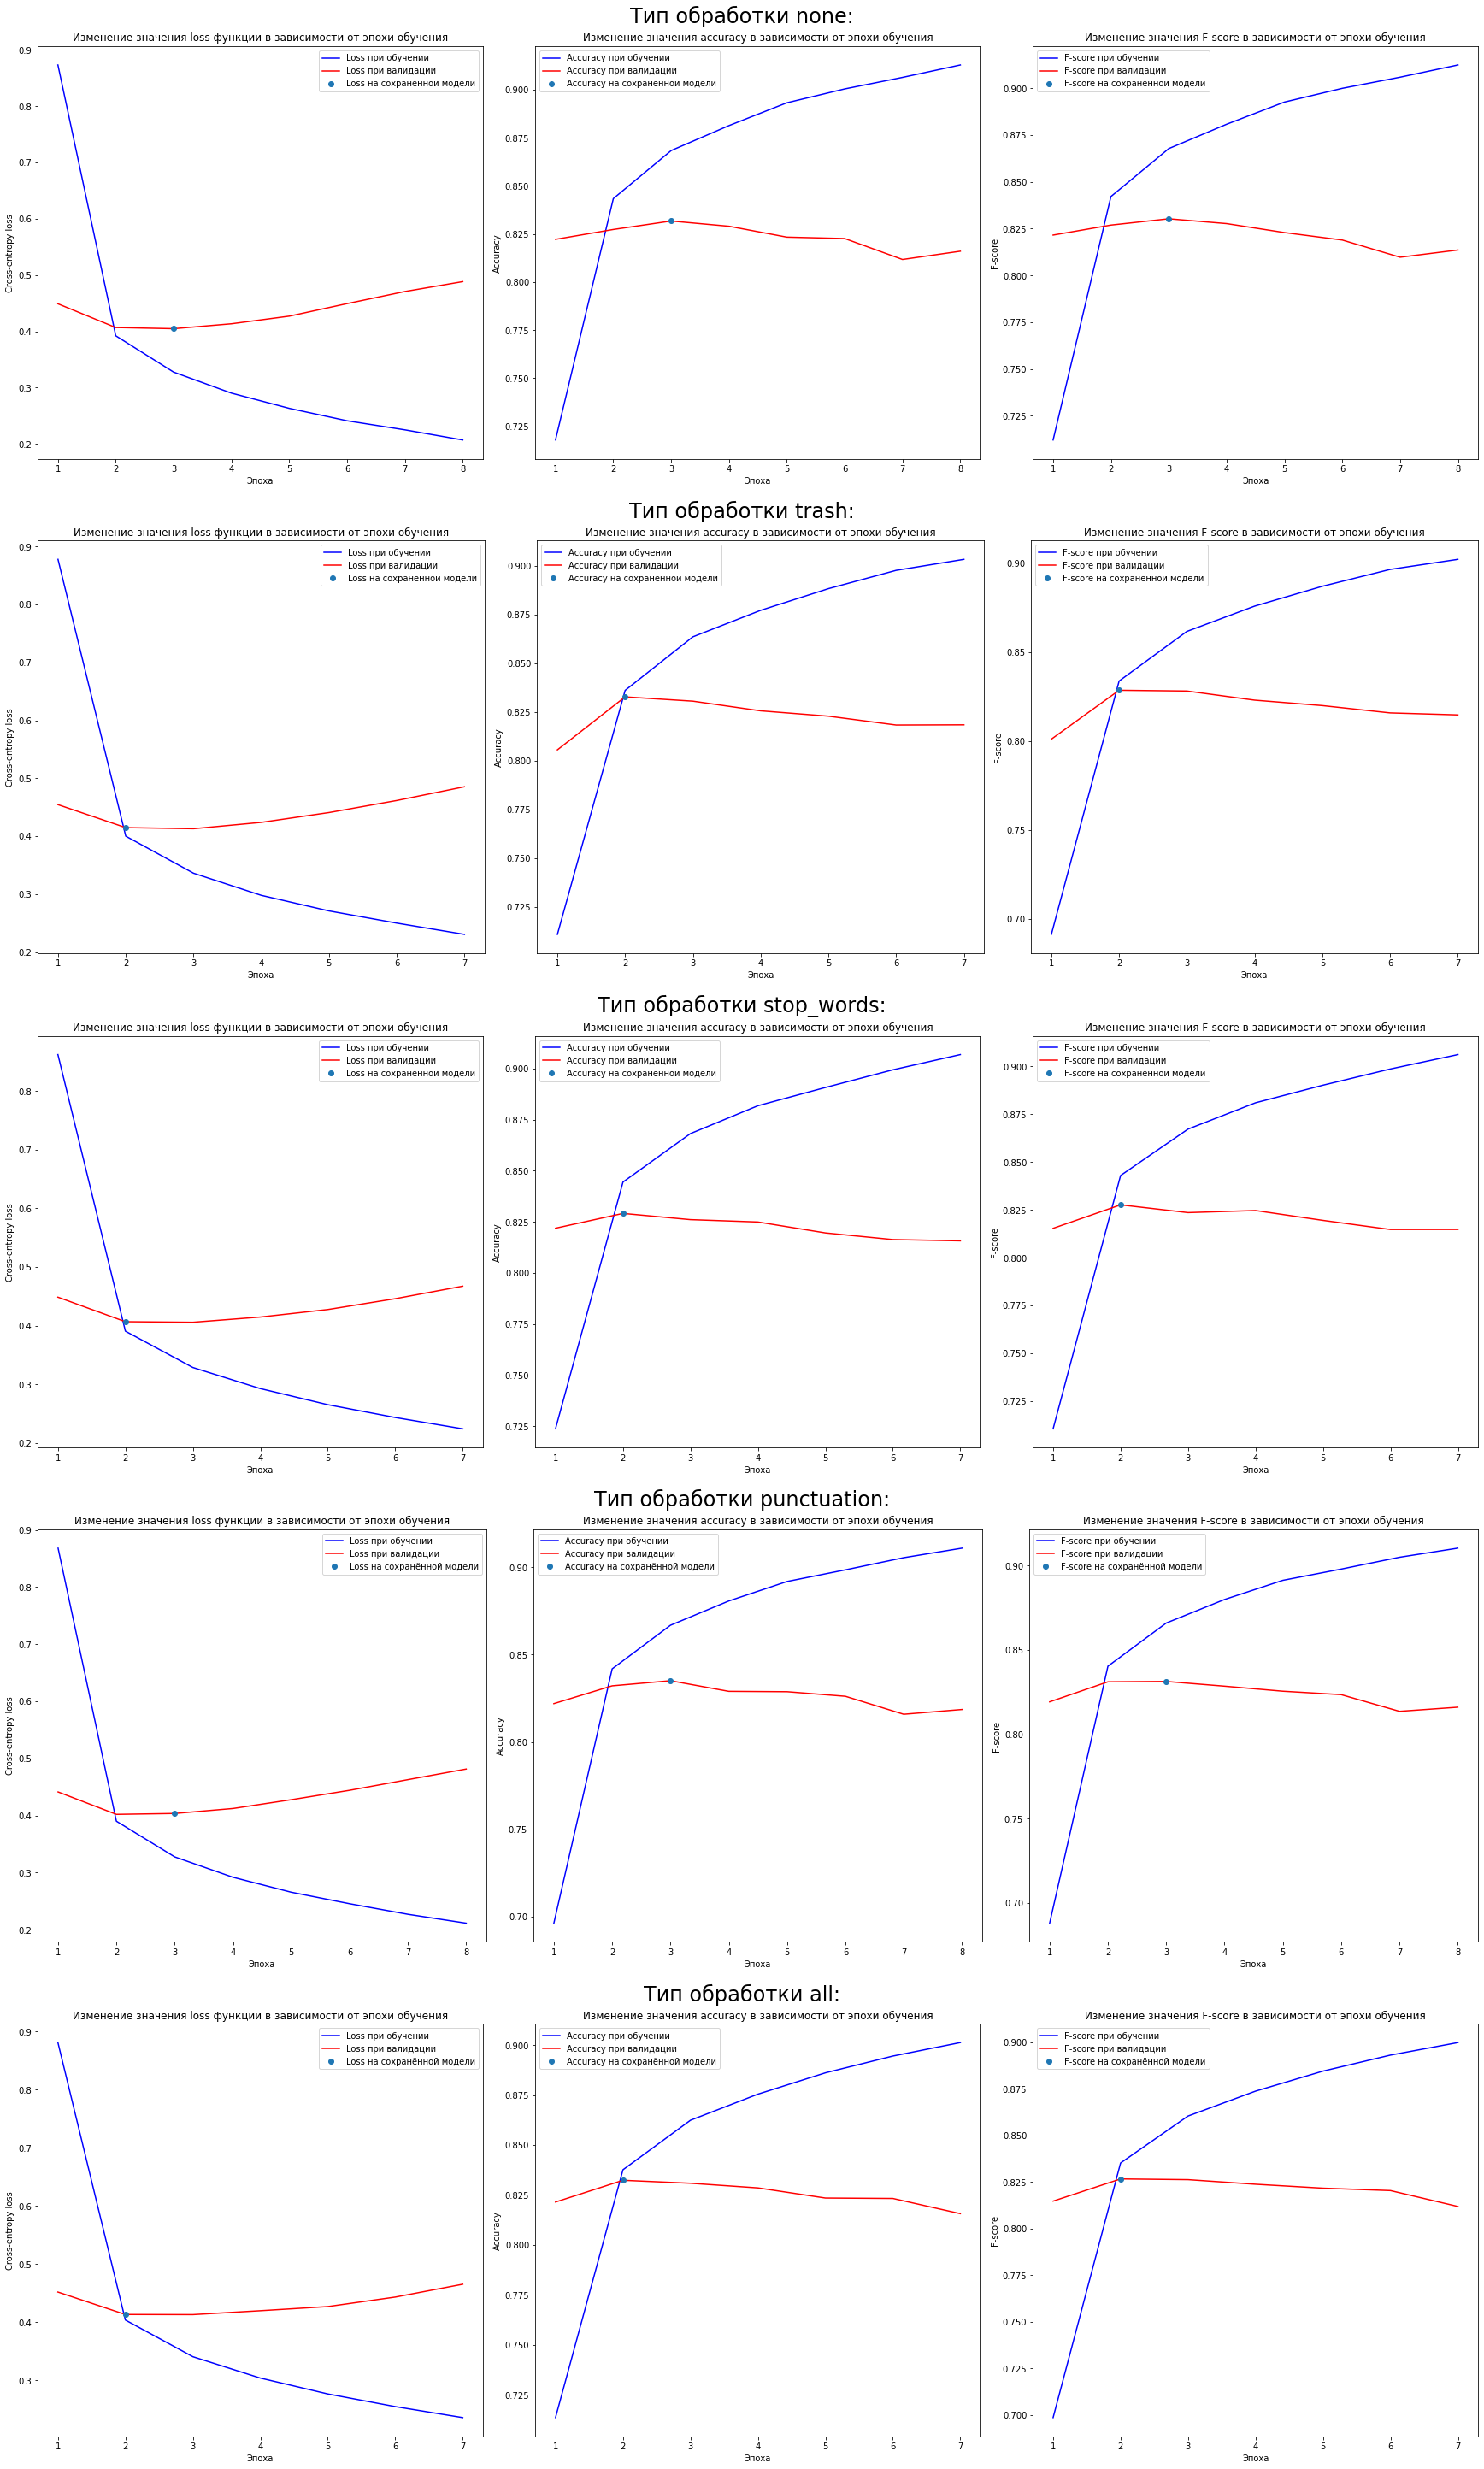

In [107]:
plot_history(history) # вывод истории обучения

Оцениваем качество предсказаний.

In [110]:
best_metric = 0 # лучшая метрика для модели
best_var = "" # название лучшей обработки данных

metrics[model_name] = {}
for var in CLEANING_VARS: # идём по вариантам обработки
    metrics[model_name][var] = max(history[var].history["val_f1_score"]) # ищем лучшую метрику
    if metrics[model_name][var] > best_metric: # ищем лучший вариант обработки данных для модели
        best_metric = metrics[model_name][var]
        best_var = var

print(f"Лучший вариант обработки для {model_name} — {best_var}. Его F-score: {best_metric}.")

Лучший вариант обработки для FC — punctuation. Его F-score: 0.8313290476799011.


In [112]:
# best_var = "punctuation" # название лучшей обработки данных
best_model = keras.models.load_model(f"{MODELS_DIR}{model_name}_tfidf_{best_var}.keras") # загружаем сохранённую модель

299/299 [==============================] - 1s 5ms/step
                     precision    recall  f1-score   support

                age       0.96      0.97      0.97      1598
          ethnicity       0.97      0.99      0.98      1592
             gender       0.87      0.86      0.87      1595
  not_cyberbullying       0.64      0.50      0.56      1589
other_cyberbullying       0.62      0.72      0.67      1564
           religion       0.94      0.96      0.95      1600

           accuracy                           0.84      9538
          macro avg       0.83      0.83      0.83      9538
       weighted avg       0.83      0.84      0.83      9538



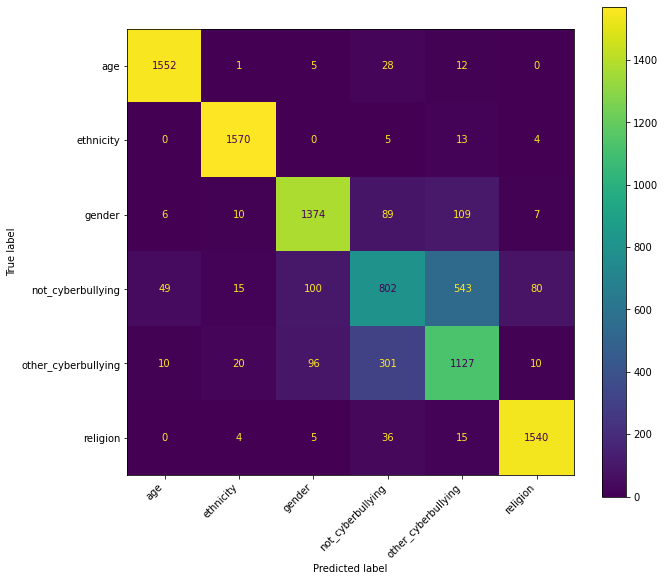

In [116]:
X_test = pd.read_csv(f"{DATA_DIR}3_splited/X_test/{best_var}_tfidf.csv", sep=',', encoding='utf8', index_col=False) # считывание данных
y_test = pd.read_csv(f"{DATA_DIR}3_splited/y_test/{best_var}_tfidf.csv", sep=',', encoding='utf8', index_col=False) # считывание данных

labels_names = y_test.columns # имена колонок
X_test, y_test = X_test.values, y_test.values # переходим от pd.DataFrame к np.array
model_evaluate(best_model, X_test, y_test, labels_names) # оцениваем предсказание лучшей модели на соответствующем типе обработки

Полносвязная нейронная сеть **отработала на уровне ансамбля простых моделей** (***accuracy=0.84, F-score=0.83***), небольшие сложности у неё возникли с теми же классами — "not_cyberbullying" и "other_cyberbullying".

Однако к существенному плюсу данной нейронной сети можно отнести скорость её обучения. Когда на тренировку ансамбля уходило порядка 500 секунд, у нейронной сети это занимает лишь 200, что что почти **в два с половиной раза быстрее**.

### 2) CNN-based нейронная сеть

В качестве второй NN попробуем использовать **Convolutional Neural Network** (CNN), хотя запуск её на сильно разреженной матрице TF-IDF вряд ли принесёт хорошие результаты.

Функция построения модели.

In [161]:
def create_model_CNN(input_size: int, target_size: int) -> Model:
    """
    Функция для создания свёрточной нейронной сети с различным shape входа.\n
    Parameters
    -------
    * input_size : ожидаемый размер входа модели (количество фич на один сэмпл данных)
    * target_size : ожидаемое число таргетов
    Returns
    -------
    * Model : созданная модель
    """
    layer_input = Input(shape=(input_size, 1), dtype=DTYPE, name='input_tfidf') # первый входной слой модели, получает вектор размера (BATCH_SIZE, число слов или токенов в строке матрицы TF-IDF)
    layer_conv_1 = Conv1D(filters=32, kernel_size=5, strides=1, padding="valid", activation="relu", use_bias=True, name='conv_1')(layer_input) # свёрточный слой, выход которого имеет размерность (BATCH_SIZE, сколько раз ядро свёртки размера kernel_size пройдёт по данным с шагом stride если нет паддинга ~ padding="valid", filters)
    layer_dropout_1 = Dropout(rate=0.05, name='dropout_1')(layer_conv_1) # слой dropout, зануляющий некоторые входы с вероятностью rate для борьбы с переобучением
    layer_conv_2 = Conv1D(filters=16, kernel_size=7, strides=1, padding="valid", activation="relu", use_bias=True, name='conv_2')(layer_dropout_1) # свёрточный слой, выход которого имеет размерность (BATCH_SIZE, units)
    layer_dropout_2 = Dropout(rate=0.1, name='dropout_2')(layer_conv_2) # слой dropout, зануляющий некоторые входы с вероятностью rate для борьбы с переобучением
    layer_conv_3 = Conv1D(filters=8, kernel_size=9, strides=1, padding="valid", activation="relu", use_bias=True, name='conv_3')(layer_dropout_2) # свёрточный слой, выход которого имеет размерность (BATCH_SIZE, units)
    layer_pooling = MaxPooling1D(pool_size=3, strides=3, padding="valid", name='max_pool_1')(layer_conv_3) # слой max пулинга для извлечения максимального элемента из срседних ячеек
    layer_flatten = Flatten(name='flatten_1')(layer_pooling) # слой для избавления от лишней размерности (последовательно объединяет данные по размерностям), выход которого имеет размерность (BATCH_SIZE, П_prev_dims)
    layer_output = Dense(units=target_size, activation="softmax", name='labels_prob')(layer_flatten) # полносвязный (линейный) слой, activation="softmax" — для получения вероятностей классов, выход будет иметь размерность (BATCH_SIZE, units)
    model = Model(inputs=layer_input, outputs=layer_output) # объединение слоёв в модель
    
    return model

In [162]:
model_example = create_model_CNN(3000, 6) # создаём модель (для примера вывода архитектуры)
model_example.summary() # вывод данных о модели

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_tfidf (InputLayer)    [(None, 3000, 1)]         0         
                                                                 
 conv_1 (Conv1D)             (None, 2996, 32)          192       
                                                                 
 dropout_1 (Dropout)         (None, 2996, 32)          0         
                                                                 
 conv_2 (Conv1D)             (None, 2990, 16)          3600      
                                                                 
 dropout_2 (Dropout)         (None, 2990, 16)          0         
                                                                 
 conv_3 (Conv1D)             (None, 2982, 8)           1160      
                                                                 
 max_pool_1 (MaxPooling1D)   (None, 994, 8)            0  

Обучение модели.

In [163]:
model_name = "CNN" # название модели

In [164]:
history = {} # словарь под историю обучения

for var in tqdm(CLEANING_VARS): # идём по вариантам обработки
    X_train = pd.read_csv(f"{DATA_DIR}3_splited/X_train/{var}_tfidf.csv", sep=',', encoding='utf8', index_col=False).values # считывание данных
    y_train = pd.read_csv(f"{DATA_DIR}3_splited/y_train/{var}_tfidf.csv", sep=',', encoding='utf8', index_col=False).values # считывание данных
    X_test = pd.read_csv(f"{DATA_DIR}3_splited/X_test/{var}_tfidf.csv", sep=',', encoding='utf8', index_col=False).values # считывание данных
    y_test = pd.read_csv(f"{DATA_DIR}3_splited/y_test/{var}_tfidf.csv", sep=',', encoding='utf8', index_col=False).values # считывание данных

    input_size = X_train.shape[1] # размер входного вектора (для одного сэмпла)
    target_size = y_train.shape[1] # размер выходного вектора (число таргетов)
    model = create_model_CNN(input_size, target_size) # создаём модель под тип обработки (из-за него отличается количество фич TF-IDF матрицы)

    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE) # оптимизатор обучения модели

    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy', keras.metrics.F1Score(average="macro")]) # компилирование модели с указанием оптимизатора, функции потерь и дополнительных метрик
    # Binary cross entropy is calculated on top of sigmoid outputs, whereas Categorical cross-entropy is calculated over softmax activation outputs.

    callback_stopping = get_early_stopping() # callback ранней остановки обучения
    callback_checkpoint = get_checkpoint_best_only(f"{model_name}_tfidf_{var}") # callback сохранения чекпоинтов
    callbacks = [callback_stopping, callback_checkpoint] # список callback_ов

    time_start = time.time() # замеряем время начала обучения
    history[var] = model.fit(x=X_train, y=y_train, validation_data=[X_test, y_test], validation_split=0, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, verbose=1) # запускаем обучение модели (результатом которого будет история изменения метрик)
    # x — вход модели
    # y — таргеты
    # epochs — число эпох обучения
    # batch_size — размер батча
    # validation_data — тестовые данные
    # validation_split — если validation_data=None, то validation_split определяет, какой процент данных будет использован для валидации (на нём не будет обучения), например 0.2
    # callbacks — список callback функций
    # verbose — на сколько подробно выводить информацию об обучении (1 - на каждой эпохе)
    print(f"Время, затраченное на обучение: {time.time()  - time_start} секунд, при обработке {var}.")
    
    # model.save(f"{MODELS_DIR}{model_name}_tfidf_{var}_final.keras") # сохранение модели (финальной, но не лучшей)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/50
764/764 [==============================] - 268s 302ms/step - loss: 1.0610 - accuracy: 0.6583 - f1_score: 0.6398 - val_loss: 0.6479 - val_accuracy: 0.7523 - val_f1_score: 0.7513
Epoch 2/50
764/764 [==============================] - 221s 289ms/step - loss: 0.5854 - accuracy: 0.7777 - f1_score: 0.7744 - val_loss: 0.5645 - val_accuracy: 0.7868 - val_f1_score: 0.7827
Epoch 3/50
764/764 [==============================] - 204s 267ms/step - loss: 0.5280 - accuracy: 0.7946 - f1_score: 0.7923 - val_loss: 0.5310 - val_accuracy: 0.7942 - val_f1_score: 0.7937
Epoch 4/50
764/764 [==============================] - 207s 271ms/step - loss: 0.5016 - accuracy: 0.8033 - f1_score: 0.8013 - val_loss: 0.5117 - val_accuracy: 0.8018 - val_f1_score: 0.7999
Epoch 5/50
764/764 [==============================] - 201s 263ms/step - loss: 0.4847 - accuracy: 0.8110 - f1_score: 0.8092 - val_loss: 0.4988 - val_accuracy: 0.8051 - val_f1_score: 0.8040
Epoch 6/50
764/764 [==============================] - 198s 2

Вывод Loss & Accuracy & F-score обучения.

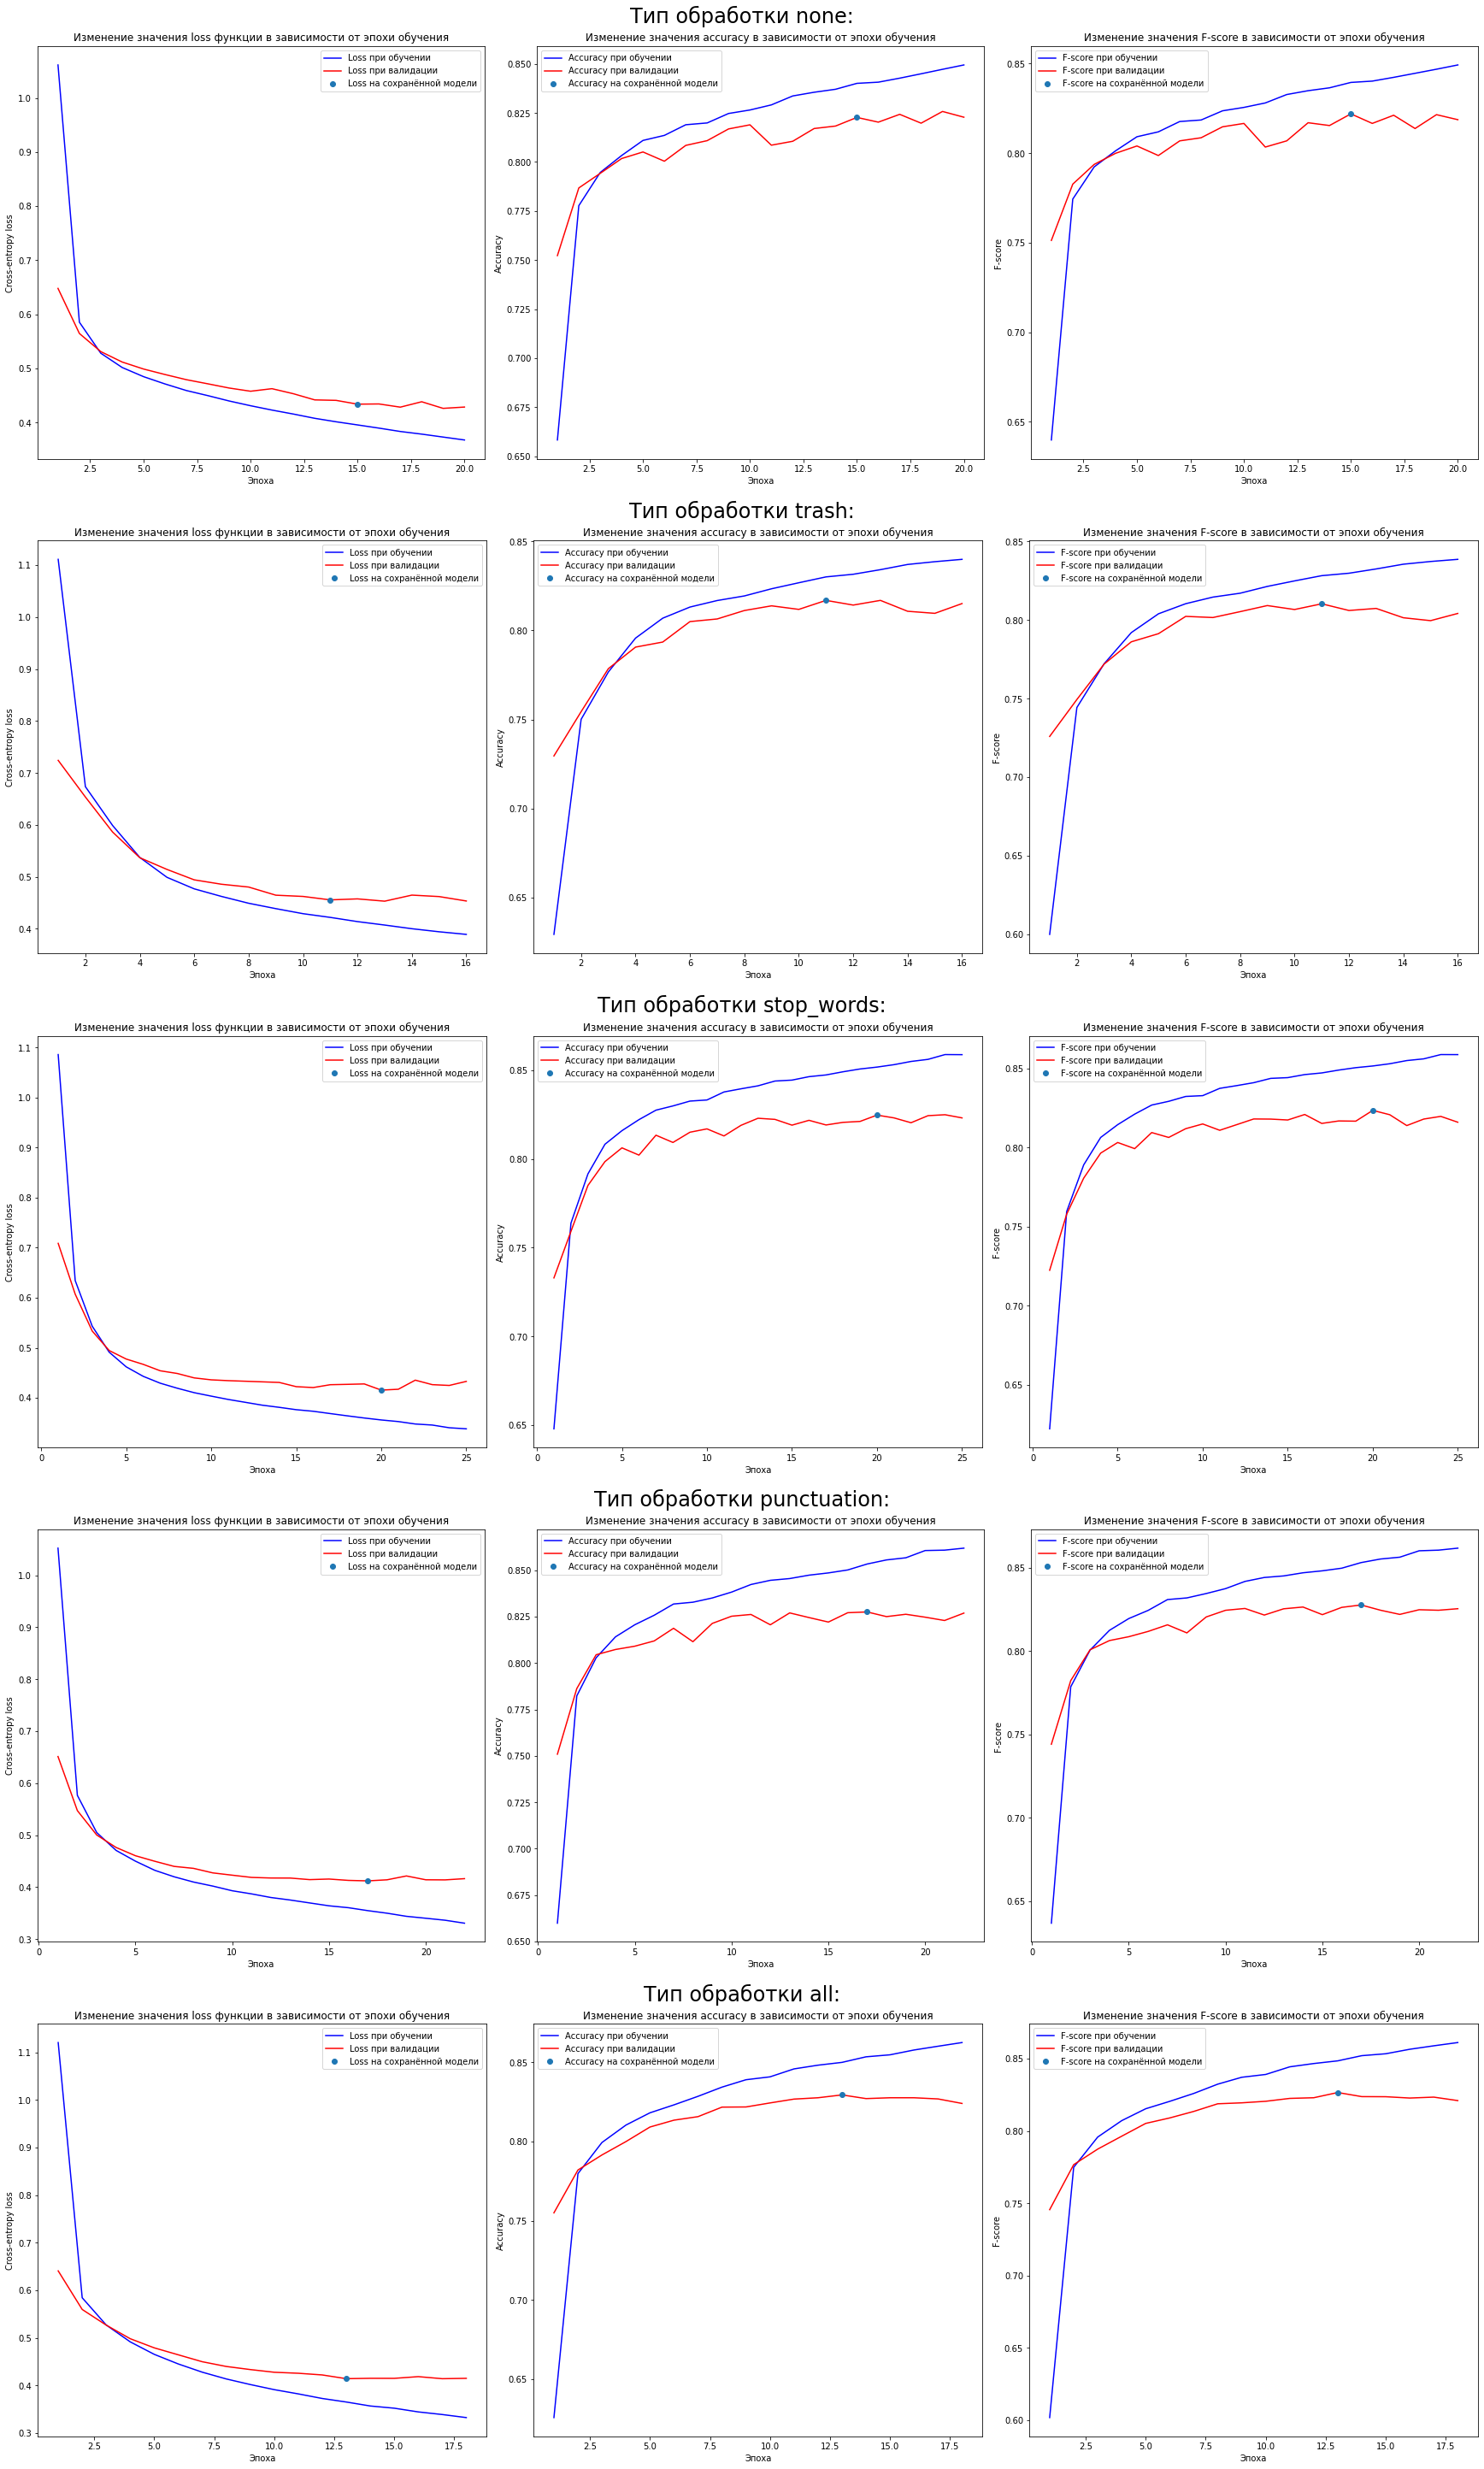

In [167]:
plot_history(history) # вывод истории обучения

Оцениваем качество предсказаний.

In [168]:
best_metric = 0 # лучшая метрика для модели
best_var = "" # название лучшей обработки данных

metrics[model_name] = {}
for var in CLEANING_VARS: # идём по вариантам обработки
    metrics[model_name][var] = max(history[var].history["val_f1_score"]) # ищем лучшую метрику
    if metrics[model_name][var] > best_metric: # ищем лучший вариант обработки данных для модели
        best_metric = metrics[model_name][var]
        best_var = var

print(f"Лучший вариант обработки для {model_name} — {best_var}. Его F-score: {best_metric}.")

Лучший вариант обработки для CNN — punctuation. Его F-score: 0.8277833461761475.


In [170]:
# best_var = "punctuation" # название лучшей обработки данных
best_model = keras.models.load_model(f"{MODELS_DIR}{model_name}_tfidf_{best_var}.keras") # загружаем сохранённую модель

299/299 [==============================] - 8s 27ms/step
                     precision    recall  f1-score   support

                age       0.98      0.97      0.98      1598
          ethnicity       0.98      0.98      0.98      1592
             gender       0.89      0.84      0.86      1595
  not_cyberbullying       0.59      0.57      0.58      1589
other_cyberbullying       0.60      0.65      0.63      1564
           religion       0.94      0.95      0.94      1600

           accuracy                           0.83      9538
          macro avg       0.83      0.83      0.83      9538
       weighted avg       0.83      0.83      0.83      9538



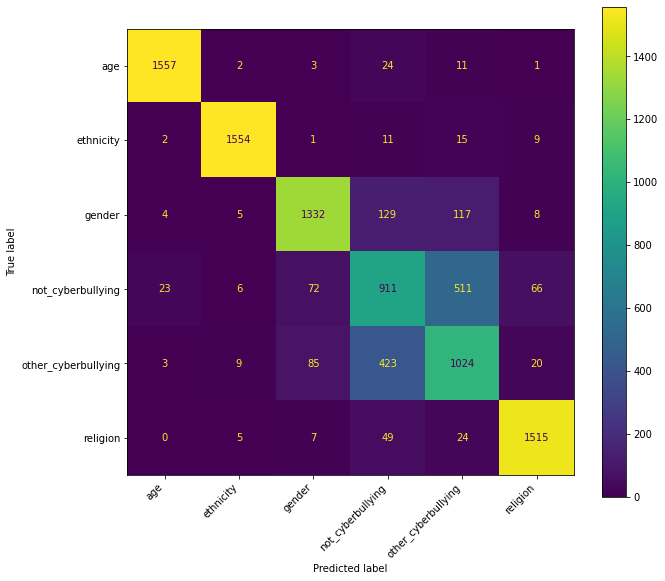

In [171]:
X_test = pd.read_csv(f"{DATA_DIR}3_splited/X_test/{best_var}_tfidf.csv", sep=',', encoding='utf8', index_col=False) # считывание данных
y_test = pd.read_csv(f"{DATA_DIR}3_splited/y_test/{best_var}_tfidf.csv", sep=',', encoding='utf8', index_col=False) # считывание данных

labels_names = y_test.columns # имена колонок
X_test, y_test = X_test.values, y_test.values # переходим от pd.DataFrame к np.array
model_evaluate(best_model, X_test, y_test, labels_names) # оцениваем предсказание лучшей модели на соответствующем типе обработки

Convolutional Neural Network добилась результатов **лишь слегка хуже, чем Fully Connected** Network. ***Accuracy меньше на одну сотую (0.83), а F-score аналогичный — 0.83***.

Стоит отметить, что при **колосальном различии числа обучаемых параметров у моделей, в 32 раза** (~52 000 CNN vs 1 701 000 FC), метрики у них получились очень схожими, НО при этом обучение CNN заняло на порядок больше времени (3000-5000 секунд CNN vs 200 секунд FC).

Благодаря малому количеству параметров — **размер CNN модели не превышает и одного мегабайта**!
![faith](./images/faith.jpg)

### 3) RNN-based нейронная сеть

Ради эксперимента рассмотрим также вариант с использованием **Recurrent Neural Network** (RNN), хотя для её корректной работы требуются последовательности токенов, отражающие их порядок в тексте, а не TF-IDF матрица.

Функция построения модели.

In [211]:
def create_model_RNN(input_size: int, target_size: int) -> Model:
    """
    Функция для создания рекуррентной нейронной сети с различным shape входа.\n
    Parameters
    -------
    * input_size : ожидаемый размер входа модели (количество фич на один сэмпл данных)
    * target_size : ожидаемое число таргетов
    Returns
    -------
    * Model : созданная модель
    """
    layer_input = Input(shape=(input_size,), dtype=DTYPE, name='input_tfidf') # первый входной слой модели, получает вектор размера (BATCH_SIZE, число слов или токенов в строке матрицы TF-IDF)
    layer_embedding = Embedding(input_dim=input_size, output_dim=EMBEDDING_DIM, input_length=input_size, name='embedding')(layer_input) # слой эмбеддинга (на вход — layer_input, выход размерности (BATCH_SIZE,  число слов или токенов в строке матрицы TF-IDF, размерность вектора-эмбеддинга))
    # input_dim — число фич/параметров, input_length — размер последовательности (в данном случае из-за TF-IDF они совпадают)

    # Reshape нужен, если вход в RNN не трёхмерный (в данном случае он трёхмерный из-за слоя Embedding)
    # return_sequences=False — возвращает вектор (двумерный) для слоя Dense (иначе — вернёт трёхмерный тензор, что мог ожидаться в следующем слое модели, что назывался бы так же ~ RNN)
    # layer_rnn_1 = SimpleRNN(units=64, activation=None, return_sequences=True, name='rnn_1')(layer_embedding) # RNN слой модели, передающий данные в следующую RNN (return_sequences=True), выход размерности (BATCH_SIZE, число слов или токенов в строке матрицы TF-IDF, units))
    # layer_rnn_2 = SimpleRNN(units=32, activation=None, return_sequences=False, name='rnn_2')(layer_rnn_1) # RNN слой модели, передающий данные в полносвязный слой (return_sequences=False), выход размерности (BATCH_SIZE, units))
    # layer_linear = Dense(units=32, activation="relu", name='dense_after_rnn')(layer_rnn_2) # полносвязный (линейный) слой после RNN из 'units' нейронов, выход будет иметь размерность (BATCH_SIZE, units)

    layer_rnn = SimpleRNN(units=64, activation=None, return_sequences=False, name='rnn_1')(layer_embedding) # RNN слой модели, передающий данные в полносвязный слой (return_sequences=False), выход размерности (BATCH_SIZE, units))
    layer_linear = Dense(units=64, activation="relu", name='dense_after_rnn')(layer_rnn) # полносвязный (линейный) слой после RNN из 'units' нейронов, выход будет иметь размерность (BATCH_SIZE, units)
    
    layer_output = Dense(units=target_size, activation="softmax", name='labels_prob')(layer_linear) # полносвязный (линейный) слой, activation="softmax" — для получения вероятностей классов, выход будет иметь размерность (BATCH_SIZE, units)
    model = Model(inputs=layer_input, outputs=layer_output) # объединение слоёв в модель
    
    return model

In [212]:
model_example = create_model_RNN(3000, 6) # создаём модель (для примера вывода архитектуры)
model_example.summary() # вывод данных о модели

Model: "model_44"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_tfidf (InputLayer)    [(None, 3000)]            0         
                                                                 
 embedding (Embedding)       (None, 3000, 100)         300000    
                                                                 
 rnn_1 (SimpleRNN)           (None, 64)                10560     
                                                                 
 dense_after_rnn (Dense)     (None, 64)                4160      
                                                                 
 labels_prob (Dense)         (None, 6)                 390       
                                                                 
Total params: 315110 (1.20 MB)
Trainable params: 315110 (1.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Обучение модели.

In [213]:
model_name = "RNN" # название модели

In [215]:
history = {} # словарь под историю обучения

for var in tqdm(CLEANING_VARS): # идём по вариантам обработки
    X_train = pd.read_csv(f"{DATA_DIR}3_splited/X_train/{var}_tfidf.csv", sep=',', encoding='utf8', index_col=False).values # считывание данных
    y_train = pd.read_csv(f"{DATA_DIR}3_splited/y_train/{var}_tfidf.csv", sep=',', encoding='utf8', index_col=False).values # считывание данных
    X_test = pd.read_csv(f"{DATA_DIR}3_splited/X_test/{var}_tfidf.csv", sep=',', encoding='utf8', index_col=False).values # считывание данных
    y_test = pd.read_csv(f"{DATA_DIR}3_splited/y_test/{var}_tfidf.csv", sep=',', encoding='utf8', index_col=False).values # считывание данных

    input_size = X_train.shape[1] # размер входного вектора (для одного сэмпла)
    target_size = y_train.shape[1] # размер выходного вектора (число таргетов)
    model = create_model_RNN(input_size, target_size) # создаём модель под тип обработки (из-за него отличается количество фич TF-IDF матрицы)

    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE) # оптимизатор обучения модели

    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=['accuracy', keras.metrics.F1Score(average="macro")]) # компилирование модели с указанием оптимизатора, функции потерь и дополнительных метрик
    # Binary cross entropy is calculated on top of sigmoid outputs, whereas Categorical cross-entropy is calculated over softmax activation outputs.

    callback_stopping = get_early_stopping(epochs_patience=2) # callback ранней остановки обучения
    callback_checkpoint = get_checkpoint_best_only(f"{model_name}_tfidf_{var}") # callback сохранения чекпоинтов
    callbacks = [callback_stopping, callback_checkpoint] # список callback_ов

    time_start = time.time() # замеряем время начала обучения
    history[var] = model.fit(x=X_train, y=y_train, validation_data=[X_test, y_test], validation_split=0, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks, verbose=1) # запускаем обучение модели (результатом которого будет история изменения метрик)
    # x — вход модели
    # y — таргеты
    # epochs — число эпох обучения
    # batch_size — размер батча
    # validation_data — тестовые данные
    # validation_split — если validation_data=None, то validation_split определяет, какой процент данных будет использован для валидации (на нём не будет обучения), например 0.2
    # callbacks — список callback функций
    # verbose — на сколько подробно выводить информацию об обучении (1 - на каждой эпохе)
    print(f"Время, затраченное на обучение: {time.time()  - time_start} секунд, при обработке {var}.")
    
    # model.save(f"{MODELS_DIR}{model_name}_tfidf_{var}_final.keras") # сохранение модели (финальной, но не лучшей)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/50
764/764 [==============================] - 1709s 2s/step - loss: 1.8043 - accuracy: 0.1662 - f1_score: 0.1266 - val_loss: 1.7916 - val_accuracy: 0.1739 - val_f1_score: 0.0623
Epoch 2/50
764/764 [==============================] - 1660s 2s/step - loss: 1.7918 - accuracy: 0.1665 - f1_score: 0.1523 - val_loss: 1.7916 - val_accuracy: 0.1749 - val_f1_score: 0.0624
Epoch 3/50
764/764 [==============================] - 1614s 2s/step - loss: 1.7918 - accuracy: 0.1662 - f1_score: 0.1545 - val_loss: 1.7916 - val_accuracy: 0.1641 - val_f1_score: 0.0530
Epoch 4/50
764/764 [==============================] - 1616s 2s/step - loss: 1.7917 - accuracy: 0.1699 - f1_score: 0.1582 - val_loss: 1.7916 - val_accuracy: 0.1727 - val_f1_score: 0.0588
Время, затраченное на обучение: 6602.228991270065 секунд, при обработке none.
Epoch 1/50
760/760 [==============================] - 1499s 2s/step - loss: 1.7925 - accuracy: 0.1665 - f1_score: 0.1537 - val_loss: 1.7917 - val_accuracy: 0.1680 - val_f1_score:

Вывод Loss & Accuracy & F-score обучения.

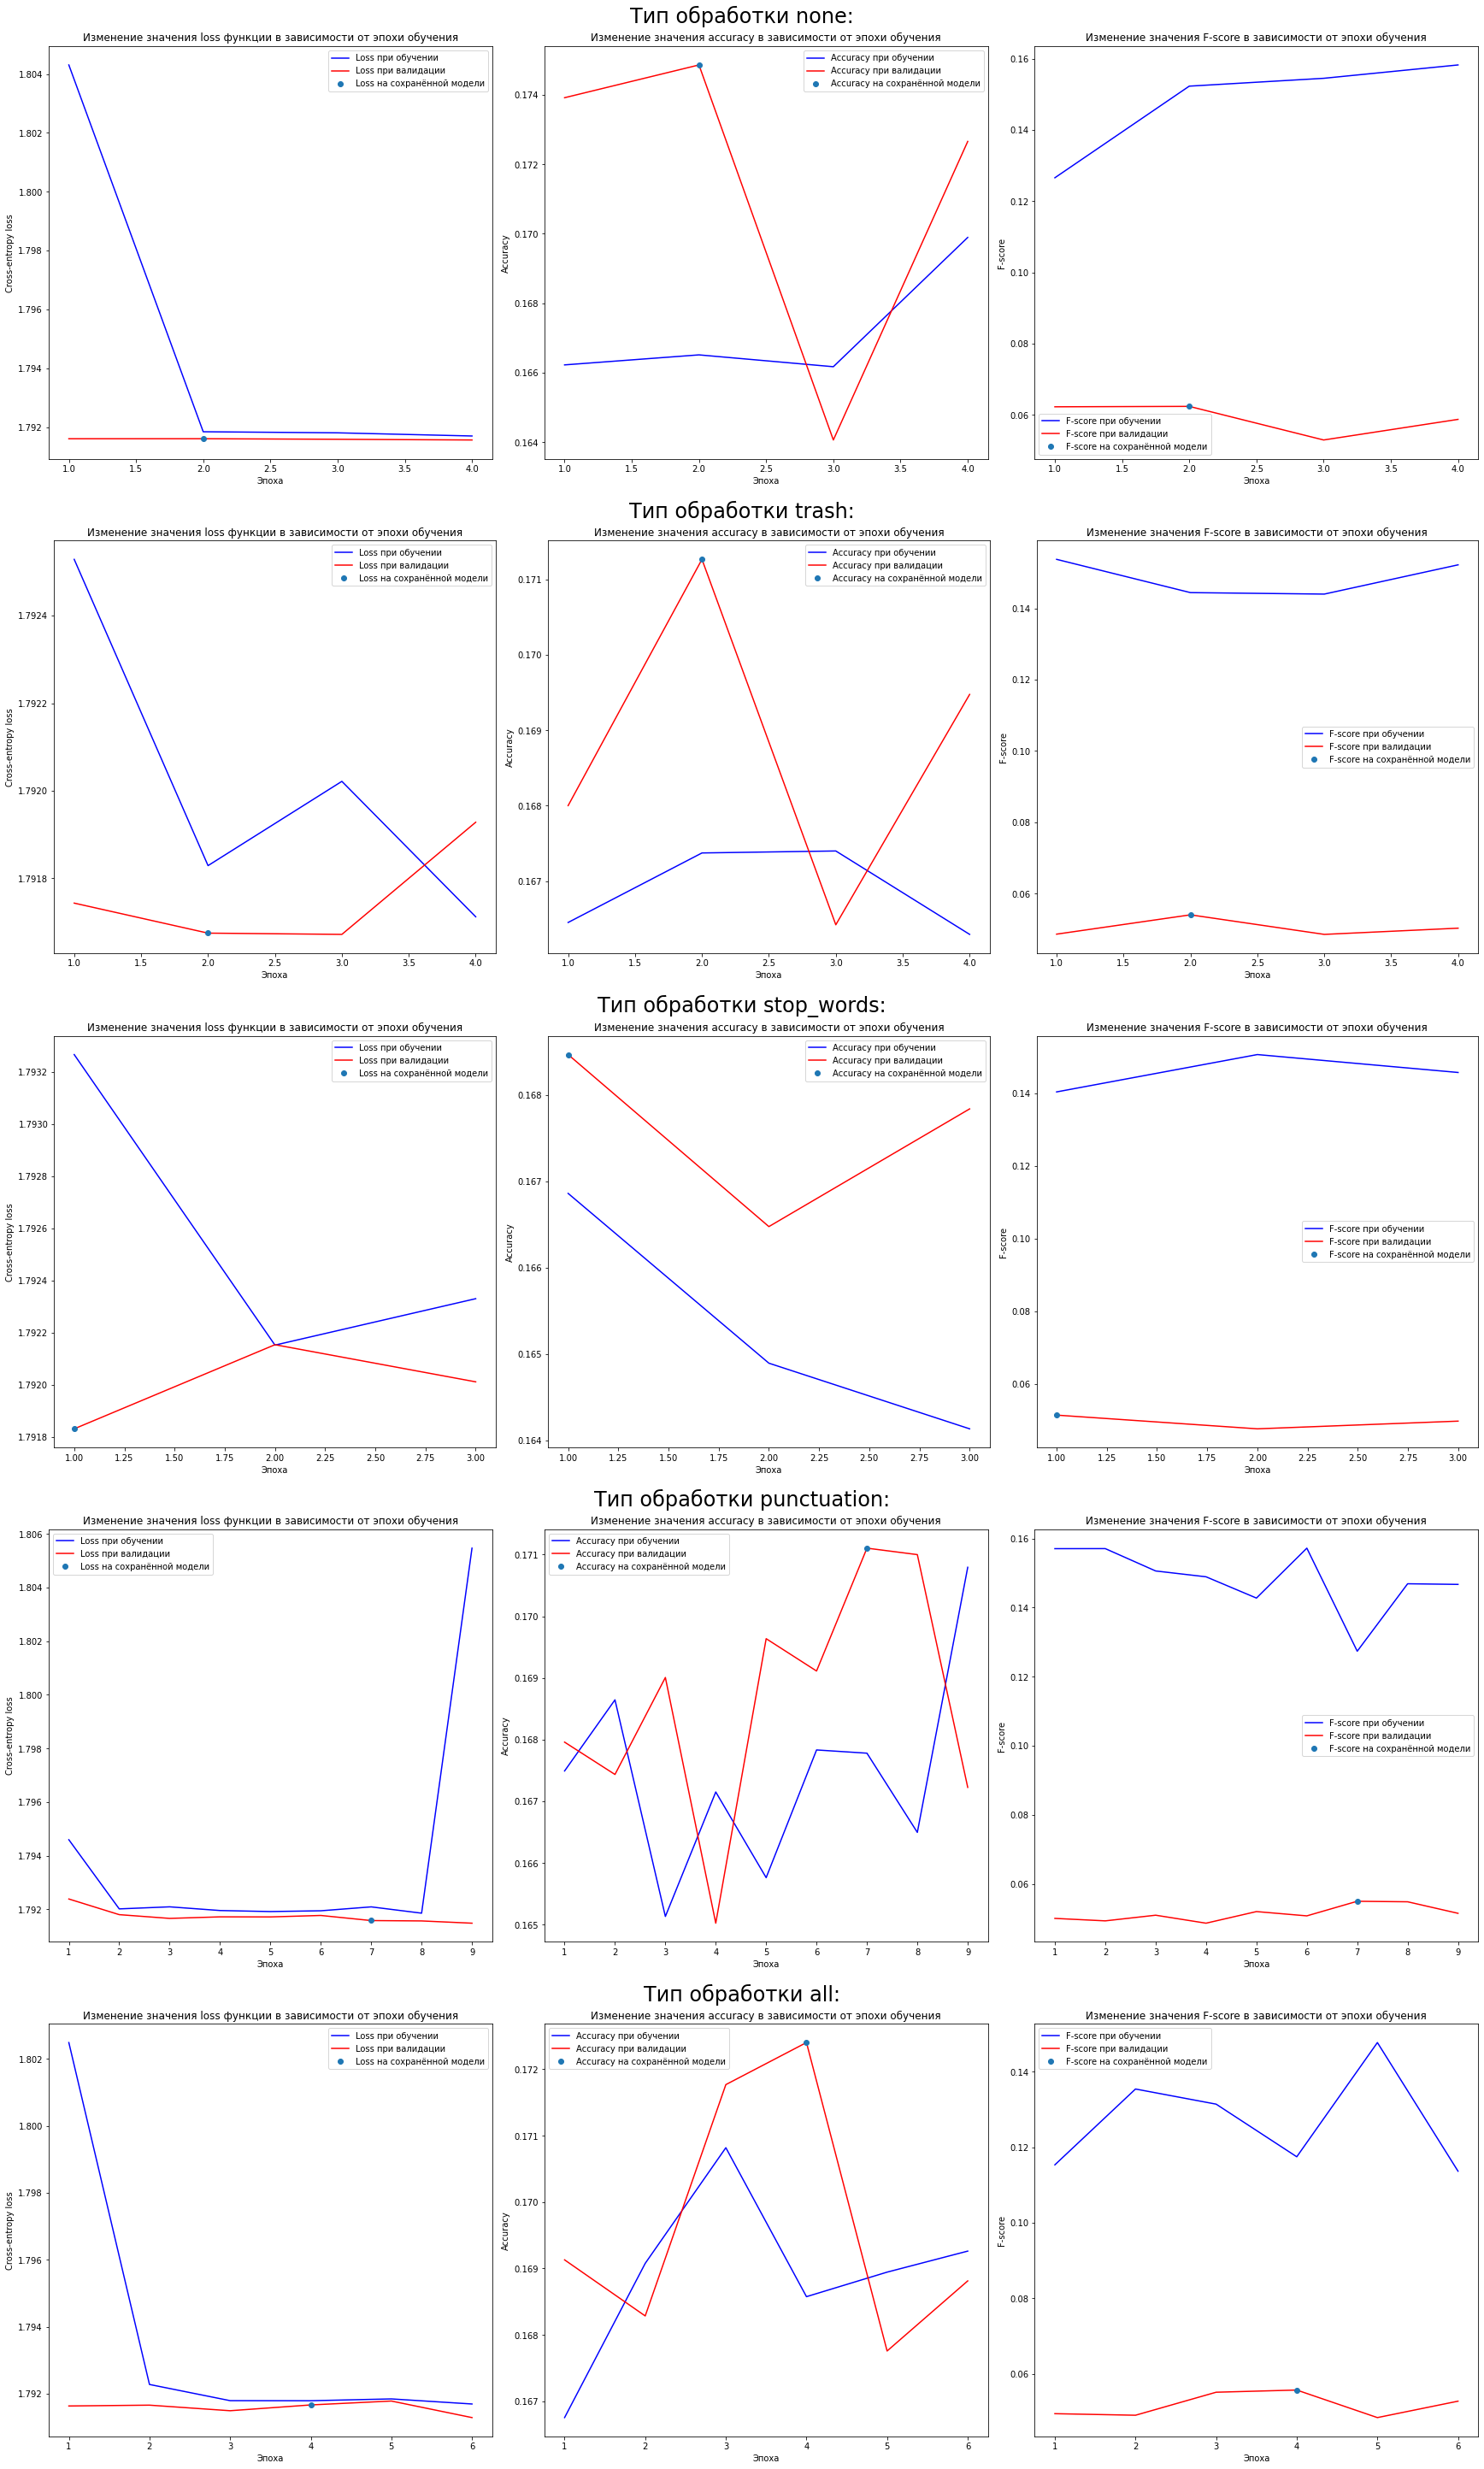

In [216]:
plot_history(history) # вывод истории обучения

Оцениваем качество предсказаний.

In [217]:
best_metric = 0 # лучшая метрика для модели
best_var = "" # название лучшей обработки данных

metrics[model_name] = {}
for var in CLEANING_VARS: # идём по вариантам обработки
    metrics[model_name][var] = max(history[var].history["val_f1_score"]) # ищем лучшую метрику
    if metrics[model_name][var] > best_metric: # ищем лучший вариант обработки данных для модели
        best_metric = metrics[model_name][var]
        best_var = var

print(f"Лучший вариант обработки для {model_name} — {best_var}. Его F-score: {best_metric}.")

Лучший вариант обработки для RNN — none. Его F-score: 0.06241805851459503.


In [218]:
# best_var = "none" # название лучшей обработки данных
best_model = keras.models.load_model(f"{MODELS_DIR}{model_name}_tfidf_{best_var}.keras") # загружаем сохранённую модель

299/299 [==============================] - 59s 196ms/step
                     precision    recall  f1-score   support

                age       0.00      0.00      0.00      1598
          ethnicity       0.25      0.00      0.00      1592
             gender       0.12      0.00      0.00      1595
  not_cyberbullying       0.46      0.02      0.04      1589
other_cyberbullying       0.55      0.02      0.04      1565
           religion       0.17      1.00      0.29      1600

           accuracy                           0.17      9539
          macro avg       0.26      0.17      0.06      9539
       weighted avg       0.26      0.17      0.06      9539



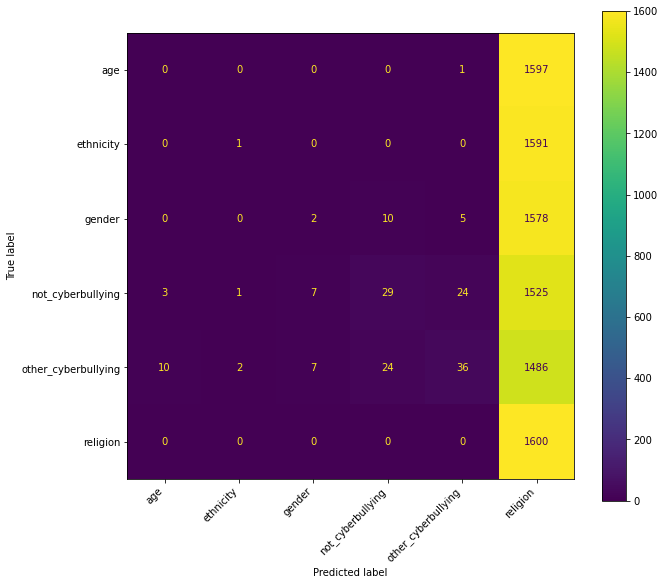

In [219]:
X_test = pd.read_csv(f"{DATA_DIR}3_splited/X_test/{best_var}_tfidf.csv", sep=',', encoding='utf8', index_col=False) # считывание данных
y_test = pd.read_csv(f"{DATA_DIR}3_splited/y_test/{best_var}_tfidf.csv", sep=',', encoding='utf8', index_col=False) # считывание данных

labels_names = y_test.columns # имена колонок
X_test, y_test = X_test.values, y_test.values # переходим от pd.DataFrame к np.array
model_evaluate(best_model, X_test, y_test, labels_names) # оцениваем предсказание лучшей модели на соответствующем типе обработки

Как и ожидалось, **RNN не предназначен для работы с TF-IDF матрицей**. Его предсказания как на обучающей, так и на тестовой выборке не имеют смысла.

# Сравнение качества/Выводы

In [233]:
# with open(f"./metrics/metrics.pkl", 'wb') as f: # открытие файла для бинарной ('b') записи ('w')
#     pickle.dump(metrics, f) # сохраняем модель

In [123]:
cmap = LinearSegmentedColormap.from_list("from_red_to_green", [(1, 0.15, 0.15), (0, 0.6, 0)], N=1000) # собственная цветовая палитра (числа в формате RGB от 0 до 1 то есть 255/255)

Для упрощения наглядности используем цветовую палитру от красного (худшего результата) до зелёного (лучшего результата).

### Сравнение подходов по строке (*варианту предобработки текста*):

*В таблице представлены результаты (их F-score) работы всех моделей при различных вариантах предобработки.*

In [231]:
pd.DataFrame(metrics).style.background_gradient(cmap=cmap, axis=1).set_properties(**{'color': 'black'}) # сравнение вариантов по строке (варианту предобработки текста)

,KNN,RF,SE,FC,CNN,RNN
none,0.398758,0.299707,0.823380,0.830269,0.821965,0.062418
trash,0.399048,0.308802,0.817289,0.828478,0.810344,0.054034
stop_words,0.406795,0.299095,0.822029,0.827632,0.823476,0.051395
punctuation,0.407746,0.397307,0.832524,0.831329,0.827783,0.055001
all,0.405603,0.386052,0.824132,0.826597,0.826574,0.055721


Анализируя F-score всех моделей отчетливо видно разделение по качеству:
* Лучшего всего справились: **Stacking Ensemble**, **Fully Connected Neural Network** и **Convolutional Neural Network**. У них F-score примерно одинаковый, >0.8, как и accuracy. 
* Отдельно от ансамбля, **KNN** и **Random Forest** продемонстрировали посредственные предсказания, плохо определяя некоторые классы или не различая их вовсе.
* **RNN** же не предназначен для работы с TF-IDF матрицей, его метрики в таблице присутствуют только для демонстрации результатов эксперимента.

*Ниже, для более точного сравнения, рассмотрены только лучшие классификаторы.*

In [237]:
pd.DataFrame(metrics)[["SE", "FC", "CNN"]].style.background_gradient(cmap=cmap, axis=1).set_properties(**{'color': 'black'}) # сравнение лучших вариантов по строке (варианту предобработки текста)

,SE,FC,CNN
none,0.823380,0.830269,0.821965
trash,0.817289,0.828478,0.810344
stop_words,0.822029,0.827632,0.823476
punctuation,0.832524,0.831329,0.827783
all,0.824132,0.826597,0.826574


Можно заметить, что **Fully Connected Neural Network** выигрывает почти при любом типе обработки, кроме одного — "*punctuation*", где его побил **Stacking Ensemble**, набрав наивысший F-score за все эксперименты с моделями.

### Сравнение подходов по столбцу (*типу классификатора*):

In [238]:
pd.DataFrame(metrics).style.background_gradient(cmap=cmap, axis=0).set_properties(**{'color': 'black'}) # сравнение вариантов по столбцу (типу классификатора)

,KNN,RF,SE,FC,CNN,RNN
none,0.398758,0.299707,0.823380,0.830269,0.821965,0.062418
trash,0.399048,0.308802,0.817289,0.828478,0.810344,0.054034
stop_words,0.406795,0.299095,0.822029,0.827632,0.823476,0.051395
punctuation,0.407746,0.397307,0.832524,0.831329,0.827783,0.055001
all,0.405603,0.386052,0.824132,0.826597,0.826574,0.055721


Вывод по обработке данных:
* Среди типов очистки почти везде победило удаление пунктуации (со спец-символов) — **punctuation**. 
* Чуть хуже себя показала полная очистка датасета (**all**), хотя она и включает в себя предыдущий пункт.
* Исключение стоп-слов (**stop_words**) и полное отсутствие очистки (**none**) имеют примерно одинаковые результаты. Однако, при использовании их в *Random Forest*, он показал значительно хуже метрики, чем при описанных выше вариантах.
* Хуже всего результаты моделей были при удалении мусорных значений (**trash**). F-score оказался даже хуже, чем при отсутствии очистки (предположительно, среди мусорных слов были и важные для определения классов).

**Плюсы и минусы рассмотренных моделей.**
<pre>
1) <b>KNN</b>:
+ Быстрое обучение, даже с перебором параметров (~575 секунд).
- Плохие результаты на рассматриваемых данных.
- Огромный размер сохраняемой модели (~1 Gb).
2) <b>Random Forest</b>:
+ Очень быстрое обучение, даже с перебором параметров (~350 секунд).
+ Минимальный размер сохраняемой модели (~400 Kb).
- Плохие результаты на рассматриваемых данных.
3) <b>Stacking Ensemble</b>:
+ Одни из лучших результатов.
~ Время обучения зависит от используемых подмоделей (~500 секунд без перебора параметров).
~ Размер ансамбля сильно зависит от используемых подмоделей.
4) <b>Fully Connected Neural Network</b>:
+ Одни из лучших результатов.
+ Очень быстрое обучение (~200 секунд на всю модель). 
~ Может занимать много памяти из-за большого количества параметров.
5) <b>Convolutional Neural Network</b>:
+ Очень скромное количество обучаемых параметров.
+ Малый размер сохранённой модели (~700 Kb).
+ Одни из лучших результатов, даже при работе на разреженной TF-IDF матрице.
- Довольно долгое обучение (3000-5000 секунд).
6) <b>Recurrent Neural Network</b>:
~ Не может быть использована с TF-IDF матрицей. 
</pre>

**Подытожим:**
1) На представленных данных лучше всего использовать предобработку, удаляющую ***пунктуацию*** (и специальные символы) или ***полную очистку*** датасета, включающую в себя как удаление мусора, стоп-слов, так и ту же пунктуацию.
2) Простые модели плохо подошли для классификации текста при использовании TF-IDF матрицы, однако их ***ансамбль*** показал результаты *на уровне* маловесных ***нейронных сетей***.
3) Если модель не предназначена для работы с TF-IDF матрицей, то это не просто так.

In [245]:
!pipreqsnb "./" # вывод зависимостей Jupyter Notebook (РЕКОМЕНДУЕТСЯ ПЕРЕПРОВЕРИТЬ РУКАМИ)

pipreqs  ./

Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
INFO: Successfully saved requirements file in ./requirements.txt
